# **Data and Information Quality Project - AA 2025/2026**
Gruppo 13 - dataset 9 \
Silvia Ferrara, Alessia Mitrano, Vittorio La Rosa

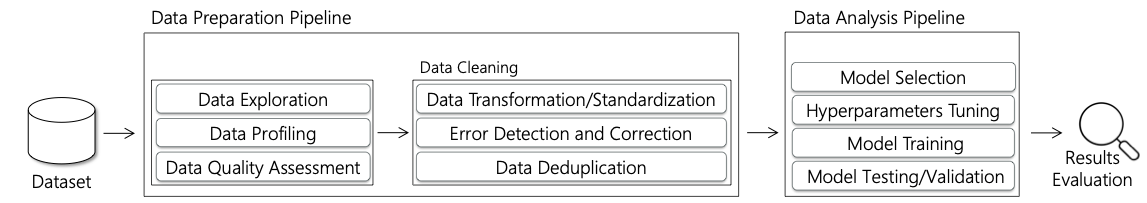

# **Libraries:**

In [751]:
!pip install recordlinkage

In [752]:
!pip install thefuzz

In [753]:
# Importing similarity distances libraries
!pip install pyphonetics jaro-winkler recordlinkage

In [754]:
# DataFrame manipulation:
import pandas as pd
# Numerical operations:
import numpy as np
# Handling timestamps with timezone awareness
from datetime import datetime, UTC
now = datetime.now(UTC)
# Base plotting library
import matplotlib.pyplot as plt

import seaborn as sns

# Regular expressions
import re
# Unicode normalization: remove accents, standardize text
import unicodedata
# Entity resolution/duplicate detection
import recordlinkage
from recordlinkage.datasets import load_febrl1
# Fuzzy matching/phonetics
from thefuzz import process, fuzz
import jellyfish

import missingno as mno

from collections import defaultdict
# Similarity distance
import jaro
from pyphonetics import Soundex
# Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Analysis
from sklearn.preprocessing import StandardScaler
import time as time
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Dataset 9:**

In [755]:
# Loading the .csv file as a pandas DataFrame
url_dataset = "https://raw.githubusercontent.com/alemitrano/DIQ_Project_Gruppo13/main/Comune-di-Milano-Esercizi-di-vicinato-in-sede-fissa.csv"
ESE = pd.read_csv(url_dataset,sep=';',encoding='unicode_escape')

In [756]:
ese = ESE.copy()

# **Data Profiling & Quality Assessment**

**General dataset information**

In [757]:
# Sizes of the dataset
print(f"Dataset sizes: {ESE.shape}\n")

# Dataset's columns
columns = list(ESE.columns)
print(f"Dataset columns: {columns}\n")

# Dataset's types
print(f"Dataset columns types:\n{ESE.dtypes}\n")

# Printing numerical and categorical columns
numeric_cols = ESE.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ESE.select_dtypes(include=['object']).columns

print(f"\nColonne Numeriche: {list(numeric_cols)}")
print(f"Colonne Categoriche: {list(categorical_cols)}")


Dataset sizes: (24136, 13)

Dataset columns: ['Settore Merceologico', 'Insegna', 'Ubicazione', 'Tipo via', 'Via', 'Civico', 'Codice via', 'ZD', 'Settore Storico Cf Preval', 'Superficie Vendita', 'Superficie Altri Usi', 'Superficie Tabelle Speciali', 'Superficie Totale']

Dataset columns types:
Settore Merceologico            object
Insegna                         object
Ubicazione                      object
Tipo via                        object
Via                             object
Civico                          object
Codice via                      object
ZD                             float64
Settore Storico Cf Preval       object
Superficie Vendita             float64
Superficie Altri Usi           float64
Superficie Tabelle Speciali    float64
Superficie Totale              float64
dtype: object


Colonne Numeriche: ['ZD', 'Superficie Vendita', 'Superficie Altri Usi', 'Superficie Tabelle Speciali', 'Superficie Totale']
Colonne Categoriche: ['Settore Merceologico', 'Insegna', '

**Dataset data duplication level**

In [758]:
# Checking how many duplicated rows are in the dataset
print("Total number of exactly duplicated rows: ", ESE.duplicated().sum())

# Printing the number of distinct elements for each column and the distinct values
print("\nNumber of distinct values by columns:\n")
columns = list(ESE.columns)
num_distinct_elems = [[col, ESE[col].nunique()] for col in columns]

for elem in num_distinct_elems:
    if elem[1] <= 20:
      print(f"{elem[0]}: {elem[1]} -> {ESE[elem[0]].unique()}")
    else:
      print(f"{elem[0]}: {elem[1]}")

Total number of exactly duplicated rows:  32

Number of distinct values by columns:

Settore Merceologico: 56
Insegna: 5583
Ubicazione: 16907
Tipo via: 20 -> ['CSO' 'LGO' 'PLE' 'PZA' 'VIA' 'VLE' 'RIP' 'ALZ' 'BST' 'FOR' 'GLL' 'PAS'
 'PTA' 'VIE' 'LARGO' 'GRD' 'SDA' 'SIT' nan '7' 'VLO']
Via: 2331
Civico: 386
Codice via: 2348
ZD: 10 -> [ 1.  4.  5.  8.  6.  3.  9.  7.  2. nan 60.]
Settore Storico Cf Preval: 2228
Superficie Vendita: 250
Superficie Altri Usi: 438
Superficie Tabelle Speciali: 117
Superficie Totale: 642


In [759]:
# Given the large number of distinct values in ‘Settore Storico Cf Preval’, despite fewer expected, we list them
display(pd.Series(ESE['Settore Storico Cf Preval'].unique()))

,0
0,speciale panificatori
1,NaN
2,prod. agricolo alim/non alim
3,ESERCIZIO DI VICINATO
4,COMMERCIO AL DETTAGLIO
...,...
2224,RIVENDITA MONOPOLIO
2225,COMMERCIO AL DETTAGLIO GENERI DI MONOPOLIO
2226,TABELLA SPECIALE MONOPOLIO
2227,vendita al dettaglio


**Null values**

In [760]:
# Show whether an attribute of a certain row of the dataset is NULL or not
ESE.isnull()

,Settore Merceologico,Insegna,Ubicazione,Tipo via,Via,Civico,Codice via,ZD,Settore Storico Cf Preval,Superficie Vendita,Superficie Altri Usi,Superficie Tabelle Speciali,Superficie Totale
0,True,True,False,False,False,False,False,False,False,False,True,True,False
1,True,True,False,False,False,False,False,False,True,False,False,True,False
2,True,True,False,False,False,False,False,False,False,False,True,True,False
3,True,True,False,False,False,False,False,False,True,False,True,True,False
4,True,True,False,False,False,False,False,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24131,False,True,False,False,False,False,False,False,False,False,False,False,False
24132,False,False,False,False,False,False,False,False,False,False,True,True,False
24133,False,False,False,False,False,False,False,False,False,False,False,True,False
24134,False,True,False,False,False,False,False,False,False,False,False,False,False


In [761]:
# Display the number of NULL values for each column
NULL_VAL_PER_COL = ESE.isnull().sum()
print(f"Number of NULL values for each column:\n\n{NULL_VAL_PER_COL}")

Number of NULL values for each column:

Settore Merceologico             105
Insegna                        17147
Ubicazione                         1
Tipo via                           2
Via                                1
Civico                           650
Codice via                         2
ZD                                 2
Settore Storico Cf Preval         33
Superficie Vendita                30
Superficie Altri Usi           15098
Superficie Tabelle Speciali    23009
Superficie Totale                 36
dtype: int64


**Accuracy evaluation**\
We check for syntactic accuracy

Accuracy for "ZD" column:

In [762]:
#Calculate di accuracy of the ZD column
ZD_domain = [1,2,3,4,5,6,7,8,9]
correct_ZD = ESE['ZD'].isin(ZD_domain).sum()
not_null_ZD = ESE['ZD'].count()
accuracy = correct_ZD/not_null_ZD
print(f"Accuracy of the ZD column: {accuracy*100}%")

Accuracy of the ZD column: 99.99585646805336%


Accuracy for "Codice Via" column:

In [763]:
#Calculate the accuracy of the column 'Codice via' by checking that the code is composed of 3 or 4 digits
temp_codice = pd.to_numeric(ESE['Codice via'], errors='coerce').fillna(0)   # temporary copy

correct_codice_via = temp_codice.between(100, 9999).sum()
not_null_codice_via = ESE['Codice via'].count()

accuracy = correct_codice_via/not_null_codice_via
print(f"Accuracy: {accuracy*100}%")

Accuracy: 99.76796221098864%


**Completeness evaluation**

Overall Dataset Completeness: 82.12%

Critical columns:
                             Missing Values  Percentage
Superficie Tabelle Speciali           23009   95.330626
Insegna                               17147   71.043255
Superficie Altri Usi                  15098   62.553861
Civico                                  650    2.693073
Settore Merceologico                    105    0.435035
Superficie Totale                        36    0.149155
Settore Storico Cf Preval                33    0.136725
Superficie Vendita                       30    0.124296
Tipo via                                  2    0.008286
ZD                                        2    0.008286
Codice via                                2    0.008286
Via                                       1    0.004143
Ubicazione                                1    0.004143




/tmp/ipython-input-309169698.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_df.index, y=missing_df['Percentage'], palette="Reds_r")


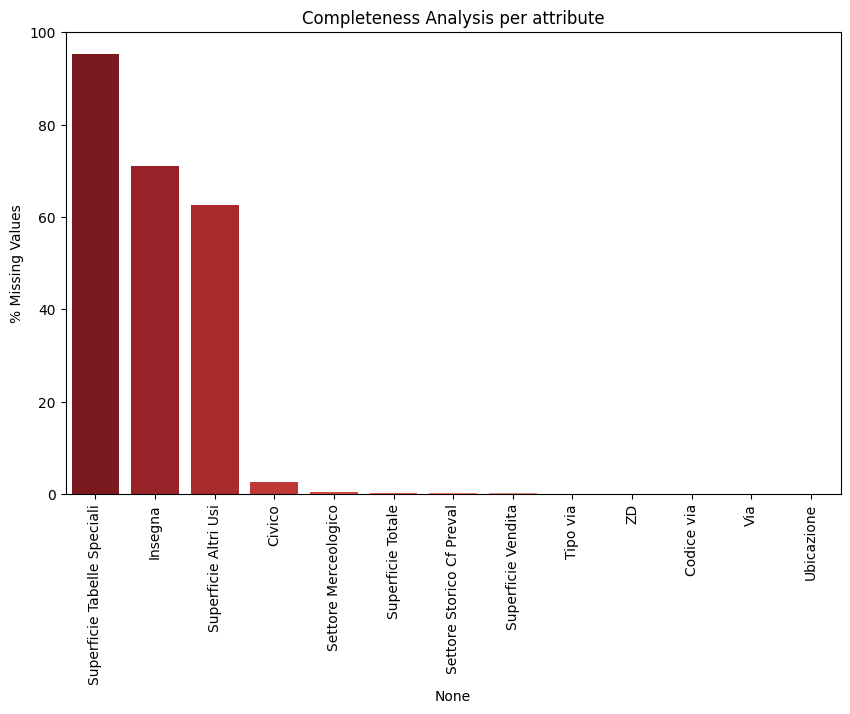

In [764]:
# Completeness evaluation
total_cells = ESE.size
missing_cells = ESE.isnull().sum().sum()
completeness_ratio = (1 - (missing_cells / total_cells)) * 100

print(f"Overall Dataset Completeness: {completeness_ratio:.2f}%")

# By column
missing_df = pd.DataFrame({'Missing Values': ESE.isnull().sum(), 'Percentage': (ESE.isnull().sum() / len(ESE)) * 100
}).sort_values(by='Percentage', ascending=False)

print("\nCritical columns:")
print(missing_df[missing_df['Percentage'] > 0])

# Graphic visualisation
print('\n')
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_df.index, y=missing_df['Percentage'], palette="Reds_r")
plt.xticks(rotation=90)
plt.title("Completeness Analysis per attribute")
plt.ylabel("% Missing Values")
plt.show()

**Consistency Evaluation** \
For what concern the consistency, we check whether some integrity contraints referred to some columns of the dataset are respected. \
In particular we check:
1. If the values in the "Superficie Totale" column are greater than 0 (it wouldn't make sense to have a negative surface)
2. Address information contained in the column 'Ubicazione' are the same of the respective columns.

In [765]:
# Creating an array of the columns that will represent whether a row in the dataset has passed a specific consistency check.
PROPERTIES = ["Consistency Superficie Totale", "Consistency Tipo via", "Consistency Via", "Consistency Civico", "Consistency ZD"]

NEW_DF = ESE.copy() # working on a copy of dataset - those columns are just for analysis

# Adding the new columns and populate the rows with '1' if the check has been passed, with '0' otherwise
# N.B: In case the processed row contains a NULL value, in the consistency column we decided to put a '0' value
NEW_DF[PROPERTIES[0]] = np.where(NEW_DF['Superficie Totale']>0.0,
                                      1,
                                      0)
NEW_DF[PROPERTIES[1]] = np.where(NEW_DF['Ubicazione'].str.split(" ").str[0] == NEW_DF['Tipo via'],
                                      1,
                                      0)
NEW_DF[PROPERTIES[2]] = np.where(NEW_DF.apply(lambda row: str(row['Via']) in str(row['Ubicazione']), axis=1),
                                      1,
                                      0)
NEW_DF[PROPERTIES[3]] = np.where(NEW_DF['Ubicazione'].str.extract(r'(?:N.|n.|num.|civ.)\s*(\d+)', expand=False) == NEW_DF['Civico'],
                                      1,
                                      0)
NEW_DF[PROPERTIES[4]] = np.where(NEW_DF['Ubicazione'].str.extract(r'z.d. (\d+)', expand=False).astype(float) == NEW_DF['ZD'],
                                      1,
                                      0)
NEW_DF

,Settore Merceologico,Insegna,Ubicazione,Tipo via,Via,Civico,Codice via,ZD,Settore Storico Cf Preval,Superficie Vendita,Superficie Altri Usi,Superficie Tabelle Speciali,Superficie Totale,Consistency Superficie Totale,Consistency Tipo via,Consistency Via,Consistency Civico,Consistency ZD
0,NaN,NaN,CSO ITALIA N. 34 (z.d. 1),CSO,ITALIA,34,526,1.0,speciale panificatori,0.0,NaN,NaN,0.0,0,1,1,1,1
1,NaN,NaN,CSO LODI N. 104 (z.d. 4),CSO,LODI,104,4068,4.0,NaN,16.0,5.0,NaN,21.0,1,1,1,1,1
2,NaN,NaN,CSO LODI N. 26 (z.d. 5),CSO,LODI,26,4068,5.0,speciale panificatori,0.0,NaN,NaN,0.0,0,1,1,1,1
3,NaN,NaN,CSO SEMPIONE N. 41 (z.d. 6),CSO,SEMPIONE,41,7137,8.0,NaN,120.0,NaN,NaN,120.0,1,1,1,1,0
4,NaN,NaN,LGO SCALABRINI GIOVANNI BATTISTA N. 2 (z.d. 6),LGO,SCALABRINI GIOVANNI BATTISTA,2,5392,6.0,NaN,0.0,NaN,NaN,0.0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24131,Tabella speciale Monopolio;Alimentare,NaN,RIP DI PTA TICINESE N. 61 ; isolato:071; acces...,RIP,DI PTA TICINESE,61,5150,6.0,cartoleria cancelleria,25.0,27.0,21.0,52.0,1,1,1,1,1
24132,Tabella speciale Monopolio;Alimentare;Non Alim...,i.p.,VIA GALVANI LUIGI N. 34 ; isolato:238; accesso...,VIA,GALVANI LUIGI,34,1179,2.0,carburanti e lubrificanti,45.0,NaN,NaN,60.0,1,1,1,1,1
24133,tabella speciale monopolio;non alimentare,tabacchi noli,VIA MARINO TOMMASO N. 7 ;gll vittorio emanuele...,VIA,MARINO TOMMASO,7,204,1.0,articoli per fumatori,28.0,12.0,NaN,40.0,1,1,1,1,1
24134,Tabella speciale Monopolio;Non Alimentare,NaN,VIA ASELLI GASPARE N. 11 (z.d. 3),VIA,ASELLI GASPARE,11,3167,3.0,commercio al dettaglio,7.0,125.0,5.0,132.0,1,1,1,1,1


In [766]:
# Computing and display the consistency of the columns on which we put the constaints
for cons in PROPERTIES:
  # Retrieving the column name present in the original dataset
  COL_NAME = cons.split("Consistency ")[1]
  # Computing the number of consistent cells w.r.t. a certain column in the dataset
  CONSISTENT_CELLS = (NEW_DF[cons] == 1).sum()

  # Retrieving the total number of rows in the dataset
  TOTAL_CELLS = NEW_DF.shape[0]

  # Computing the consistency of the COL_NAME column and print it
  # N.B: In the consistency computation we consider that NULL cell do not pass the consistency checks
  CONSISTENCY = CONSISTENT_CELLS / TOTAL_CELLS
  CONSISTENCY = '{0:.1f}%'.format(CONSISTENCY * 100)
  print(f"{cons}: " + CONSISTENCY)

Consistency Superficie Totale: 97.5%
Consistency Tipo via: 98.5%
Consistency Via: 97.5%
Consistency Civico: 94.7%
Consistency ZD: 99.3%


# **Data Cleaning**

## **Data Transformation/Standardization**

**Fields standardization**

In [767]:
# Trasforming every field in uppercase:
ESE = ESE.apply(lambda col: col.str.upper() if col.dtype == "object" else col)

**Data types normalization**

Normalize "*Insegna*" column:

In [768]:
ese_insegna = ESE.copy()

def norm(s):
    if pd.isna(s):
        return s
    return re.sub(r"[^A-Z0-9]+", " ", str(s).upper()).strip()

ese_insegna["Insegna_norm"] = ese_insegna["Insegna"].map(norm)

# chiave compatta: unisce solo differenze di spazi/punteggiatura
ese_insegna["key"] = ese_insegna["Insegna_norm"].str.replace(" ", "", regex=False)

# canonico = versione più frequente per quella key
rep = ese_insegna.groupby("key")["Insegna_norm"].agg(lambda x: x.value_counts().idxmax()).to_dict()

ESE["Insegna"] = ese_insegna["key"].map(rep)

Normalize "*Codice via*" column:

In [769]:
# Normalizing column:
ESE['codice_via'] = pd.to_numeric(ESE['Codice via'], errors='coerce').astype('Int64')


print(f"Tipo colonna nuova 'codice_via': {ESE['codice_via'].dtype}")

# Removing original column to avoid semantic duplications
ESE = ESE.drop(columns=['Codice via'])

Tipo colonna nuova 'codice_via': Int64


**Fields extraction from "Ubicazione"**

Extract "Tipo via", "Via", "Civico", "ZD" from "*Ubicazione*":

In [770]:
# Pattern Indirizzo: Cattura la prima parola (Tipo), tutto ciò che c'è in mezzo (Via), e il numero dopo "N." (Civico)
regex_indirizzo = r'^(?P<Tipo_estratto>\w+)\s+(?P<Via_estratta>.+?)\s+N\.\s*(?P<Civico_estratto>[0-9/a-zA-Z-]+)'

# Pattern ZD: Cerca "z.d." seguito da un numero
regex_zd = r'z\.d\.\s*(?P<ZD_estratta>\d+)'


print("Extracting data from 'Ubicazione'...")

# Extracting Address (Tipo, Via, Civico)
extracted_addr = ESE['Ubicazione'].str.extract(regex_indirizzo, flags=re.IGNORECASE)

# Extracting ZD
extracted_zd = ESE['Ubicazione'].str.extract(regex_zd, flags=re.IGNORECASE)


# Standardizziamo il testo estratto (tutto minuscolo e senza spazi extra)
#for col in ['Tipo_estratto', 'Via_estratta', 'Civico_estratto']:
 #   if col in extracted_addr.columns:
  #      extracted_addr[col] = extracted_addr[col].str.lower().str.strip()

# Conversion of ZD as a number
extracted_zd['ZD_estratta'] = pd.to_numeric(extracted_zd['ZD_estratta'], errors='coerce')


# Tipo via
ESE['Tipo via'] = extracted_addr['Tipo_estratto'].fillna(ESE['Tipo via'])

# Via
ESE['Via'] = extracted_addr['Via_estratta'].fillna(ESE['Via'])

# Civico
ESE['Civico'] = extracted_addr['Civico_estratto'].fillna(ESE['Civico'])

# ZD
ESE['ZD'] = extracted_zd['ZD_estratta'].fillna(ESE['ZD'])

print("Update completed.")
print("\nData examples (Ubicazione vs new columns):")
cols_to_check = ['Ubicazione', 'Tipo via', 'Via', 'Civico', 'ZD']
display(ESE[cols_to_check].head(10))

Extracting data from 'Ubicazione'...
Update completed.

Data examples (Ubicazione vs new columns):


,Ubicazione,Tipo via,Via,Civico,ZD
0,CSO ITALIA N. 34 (Z.D. 1),CSO,ITALIA,34,1.0
1,CSO LODI N. 104 (Z.D. 4),CSO,LODI,104,4.0
2,CSO LODI N. 26 (Z.D. 5),CSO,LODI,26,5.0
3,CSO SEMPIONE N. 41 (Z.D. 6),CSO,SEMPIONE,41,6.0
4,LGO SCALABRINI GIOVANNI BATTISTA N. 2 (Z.D. 6),LGO,SCALABRINI GIOVANNI BATTISTA,2,6.0
5,PLE STAZIONE DI PORTA GENOVA N. 2 (Z.D. 6),PLE,STAZIONE DI PORTA GENOVA,2,6.0
6,PZA ASPROMONTE N. 1 ANG.LULLI-7.4.08 TR.SET.AG...,PZA,ASPROMONTE,1,3.0
7,PZA BONOMELLI GEREMIA N. 10 (Z.D. 5),PZA,BONOMELLI GEREMIA,10,5.0
8,PZA OBERDAN GUGLIELMO N. 2 (Z.D. 1),PZA,OBERDAN GUGLIELMO,2,1.0
9,PZA SANTA MARIA DELLE GRAZIE N. 1 COMM. ELETTR...,PZA,SANTA MARIA DELLE GRAZIE,1,1.0


**Integrity check for extracted fields from "Ubicazione"**

Verify that all tuples have a **valid ZD value** (between 1 and 9):

In [771]:
# Intregrity Check: verify that all tuples have a valid ZD between 1 and 9

# Excluding NaN (those are a Completeness problem)
mask_valid = (ESE['ZD'] >= 1) & (ESE['ZD'] <= 9)
mask_invalid = (ESE['ZD'].notnull()) & (~mask_valid)

num_invalid = mask_invalid.sum()
values_invalid = ESE.loc[mask_invalid, 'ZD'].unique()

print(f"Check correct range ZD [1-9]:")
print(f" - Compliant rows: {mask_valid.sum()}")
print(f" - NOT Compliant rows: {num_invalid}")

if num_invalid > 0:
    print(f" - Uncorrect values: {values_invalid}")
    display(ESE[mask_invalid][['Insegna', 'Via', 'Civico', 'ZD']])
else:
    print("SUCCESS: ZD column has all valid values!")

Check correct range ZD [1-9]:
 - Compliant rows: 24133
 - NOT Compliant rows: 1
 - Uncorrect values: [60.]


,Insegna,Via,Civico,ZD
10008,VIA,7328,8,60.0


Display all the rows in which **"ZD" is NULL**:

In [772]:
# Display all the rows in which "ZD" is NULL
mask = ESE["ZD"].isnull()
ESE[mask]

,Settore Merceologico,Insegna,Ubicazione,Tipo via,Via,Civico,ZD,Settore Storico Cf Preval,Superficie Vendita,Superficie Altri Usi,Superficie Tabelle Speciali,Superficie Totale,codice_via
10007,NON ALIMENTARE,NaN,VIA GROSOTTO N. 7 EDIFICIO 5,VIA,GROSOTTO,7,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
13449,AUTOMOBILI,36,NaN,NaN,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


**Consistency check for columns extracted from "Ubicazione"**

 Checking unconsistency in "Tipo via" column:


In [773]:
# Check unconsistency in "Tipo via" column
split = ESE["Ubicazione"].str.split(" ")
tipo_via = split.str[0]

# Show rows where "Tipo via" is not consistent
mask = (ESE["Tipo via"] != tipo_via) & (tipo_via.notnull())
ESE[mask]

,Settore Merceologico,Insegna,Ubicazione,Tipo via,Via,Civico,ZD,Settore Storico Cf Preval,Superficie Vendita,Superficie Altri Usi,Superficie Tabelle Speciali,Superficie Totale,codice_via
191,ALIMENTARE,NaN,FF CADORNA CODVIA 9501 NUM.014 ; (Z.D. 1),CSO,GARIBALDI GIUSEPPE,113,1.0,ALIMENTARI (NOCCIOLINE SALATE) E BEVANDE.,4.0,NaN,NaN,4.0,1010
216,ALIMENTARE,NaN,MM1 LIMA CODVIA 9108 NUM.000 ; ACCESSO: ACCESS...,VIA,SETTEMBRINI LUIGI,34,3.0,BAR,2.0,NaN,NaN,2.0,2127
217,ALIMENTARE,NaN,MM1 LORETO CODVIA 9107 NUM.000 ; ISOLATO:139; ...,VIA,RONCHI,39,3.0,SALUMERIA,190.0,200.0,NaN,390.0,2655
218,ALIMENTARE,NaN,MM1 ROVERE CODVIA 9105 NUM.000 ; ISOLATO:995; ...,VIA,ARBE,33,2.0,DOLCIUMI,5.0,NaN,NaN,70.0,1352
219,ALIMENTARE,NaN,MM1 S. BAB CODVIA 9111 NUM.000 ; ISOLATO:998; ...,VIA,BANDELLO MATTEO,1,1.0,PASTICCERIA,100.0,NaN,NaN,100.0,6214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23972,TABELLA SPECIALE MONOPOLIO,TABACCHERIA,FF CADORNA CODVIA 9501 NUM.000 ; ISOLATO:164; ...,VIA,DELLA MOSCOVA,25,1.0,ARTICOLI PER FUMATORI,8.0,NaN,8.0,14.0,1016
23973,TABELLA SPECIALE MONOPOLIO,TABACCHERIA,FF PORTA G CODVIA 9407 NUM.000 ; ISOLATO:047; ...,VIA,BELLINI GENTILE,2,6.0,ARTICOLI PER FUMATORI,5.0,4.0,5.0,9.0,5387
24003,TABELLA SPECIALE MONOPOLIO,TABACCHI,FF DOMODOS CODVIA 9508 NUM.000 ; ISOLATO:026; ...,VIA,GRAN SAN BERNARDO,11,8.0,ARTICOLI PER FUMATORI,10.0,55.0,10.0,65.0,7218
24004,TABELLA SPECIALE MONOPOLIO,TABACCHI,FF LAMBRAT CODVIA 9402 NUM.000 ; ACCESSO: ACCE...,VIA,SACCARDO PIETRO ANDREA,35,3.0,ARTICOLI PER FUMATORI,16.0,NaN,NaN,76.0,2665


**New columns extraction from "Ubicazione"**

Extracting "Accesso" column:

In [774]:
# Extract "Accesso" from column "Ubicazione"
ESE["Accesso"] = ESE["Ubicazione"].str.split("ACCESSO: ").str[1].str.split(";").str[0]
ESE["Accesso"].value_counts()

,count
Accesso,
ACCESSO ESTERNO,15367
ACCESSO INTERNO,1382
AREA AP.REC.,27


In [775]:
print(ESE["Accesso"].value_counts().sum())

16776


Extracting "Isolato" column:

In [776]:
# Extract "Isolato" from "Ubicazione" column
ESE["Isolato"] = (
    ESE["Ubicazione"]
    .str.extract(r'ISOLATO:\s*(\d+)')[0]
    .fillna("NON SPECIFICATO")
)

ESE["Isolato"].value_counts()

,count
Isolato,
NON SPECIFICATO,4376
086,132
004,126
044,122
024,122
...,...
435,1
990,1
380,1


In [777]:
print(ESE["Isolato"].value_counts().sum())

24136


Extracting "Ingresso" column:

In [778]:
# Extract "Ingresso" from "Ubicazione"
ESE["Ingresso"] = ESE["Ubicazione"].astype(str).str.split("INGRESSO").str[1].str.strip().str.split(";").str[0].str.replace(r" \(z.d. \d\)", "", regex=True)
ESE["Ingresso"].value_counts()

,count
Ingresso,
VIALE SARCA,10
VIA 8502 NUM.000,2
VIA 3306 NUM.002*,2
VIA 9113 NUM.000,2
VIA FIENO,1
AL PUBBLICO DA VIA POMPEO LITTA 4 (Z.D. 1),1
VIA 9403 NUM.000,1
PTA TICINESE,1
VICOLO S. M. VALLLE (Z.D. 1),1


In [779]:
print(ESE["Ingresso"].value_counts().sum())

49


Since, as shown below, there are very few rows with a "presso" field, we do not extract a column for it:

In [780]:
# See how many rows has 'presso' inside the "Ubicazione" column
ESE["Ubicazione"].str.contains("PRESSO").sum()

4

In [781]:
# Current dataframe with all the new columns
ESE.iloc[10:15]

,Settore Merceologico,Insegna,Ubicazione,Tipo via,Via,Civico,ZD,Settore Storico Cf Preval,Superficie Vendita,Superficie Altri Usi,Superficie Tabelle Speciali,Superficie Totale,codice_via,Accesso,Isolato,Ingresso
10,NaN,NaN,PZA VIGILI DEL FUOCO N. 10 ; ISOLATO:091; ACCE...,PZA,VIGILI DEL FUOCO,10,3.0,ARTICOLI PER FUMATORI,10.0,NaN,10.0,70.0,2710,ACCESSO ESTERNO,091,NaN
11,NaN,NaN,VIA ABBA GIUSEPPE CESARE N. 32 7.4.08 TRAS.SET...,VIA,ABBA GIUSEPPE CESARE,32,9.0,"FRUTTA, VERDURA E FUNGHI",0.0,NaN,NaN,0.0,1295,NaN,058,NaN
12,NaN,NaN,VIA AIRAGHI GAETANO N. 49 PRODUTTORE AGRICOLO;...,VIA,AIRAGHI GAETANO,49,7.0,PRODUTTORE AGRICOLO ALIMENTARE,0.0,NaN,NaN,0.0,6330,NaN,NON SPECIFICATO,NaN
13,NaN,NaN,VIA AIRAGHI GAETANO N. 49 (Z.D. 7),VIA,AIRAGHI GAETANO,49,7.0,COLTIVATORE DIRETTO COMUNE DI,0.0,NaN,NaN,0.0,6330,NaN,NON SPECIFICATO,NaN
14,NaN,NaN,VIA ANELLI LUIGI N. 2 ; ISOLATO:120; (Z.D. 1),VIA,ANELLI LUIGI,2,1.0,ARTICOLI REGALO,0.0,NaN,NaN,0.0,4023,NaN,120,NaN


**Columns names transformation**

In [782]:
# Columns names transfromation
ESE.columns = (
    ESE.columns.str.strip()
               .str.lower()
               .str.replace(r"\s+", "_", regex=True)
)

In [783]:
# Check the transformation of the columns
ESE.columns

Index(['settore_merceologico', 'insegna', 'ubicazione', 'tipo_via', 'via',
       'civico', 'zd', 'settore_storico_cf_preval', 'superficie_vendita',
       'superficie_altri_usi', 'superficie_tabelle_speciali',
       'superficie_totale', 'codice_via', 'accesso', 'isolato', 'ingresso'],
      dtype='object')

**Normalization of *Settore Storico Cf Preval* column:**

In [784]:
def normalize(x):
# Keep NaN as NaN (do not convert missing to empty strings), otherwise downstream cleaning/matching may re-create missing values.
    if pd.isna(x):
        return np.nan
    x = str(x)
    x = re.sub(r"[^\w\s]", " ", x)        # rimuove punteggiatura
    x = re.sub(r"\s+", " ", x).strip()    # normalizza spazi
    return x if x else np.nan             # evita stringhe vuote

ESE["clean_settore"] = ESE["settore_storico_cf_preval"].apply(normalize)


In [785]:
# Remove typos in the new "settore storico":
ESE['clean_settore'] = ESE['clean_settore'].str.removesuffix(',an')

**Normalization of *Settore Merceologico* column:**

In [786]:
# Normalize text (uppercase, remove spurious separators, trim)
def normalize_label(x):
    if pd.isna(x):
        return np.nan
    x = str(x).upper().strip()
    # split on separators like ';' ',' and re-join unique tokens
    parts = [p.strip() for p in re.split(r"[;,]+", x) if p and p.strip()]
    parts = list(dict.fromkeys(parts))  # remove duplicates preserving order
    return ";".join(parts) if parts else np.nan

ESE["settore_merceologico"] = ESE["settore_merceologico"].apply(normalize_label)

**Elimination of redundant information**

After text normalization, the above ***cleaned sector label*** replaces the original field "**Settore Storico Cf Preval**", which is removed to avoid redundancy and ensure the use of a single canonical representation:

In [787]:
ESE = ESE.drop(columns=["settore_storico_cf_preval"])

Since each information in "**Ubicazione**" has been already extracted into new columns "Ingresso", "Isolato", "Accesso", it's possible to **drop** this column since it now contains redundant information

In [788]:
# Removing Ubicazione
ESE.drop(columns=['ubicazione'], inplace=True)

print("Actual columns in the dataset:")
print(ESE.columns.tolist())

Actual columns in the dataset:
['settore_merceologico', 'insegna', 'tipo_via', 'via', 'civico', 'zd', 'superficie_vendita', 'superficie_altri_usi', 'superficie_tabelle_speciali', 'superficie_totale', 'codice_via', 'accesso', 'isolato', 'ingresso', 'clean_settore']


## **Error Detection and Correction**

**Error** **Detection** on ***superfici*** values: \
Clearly impossible values (e.g., negative surfaces, total surface smaller than selling surface, inconsistent component sums) were identified as data errors.

In [789]:
# No negative values in Superfici
cols_area = ["superficie_vendita", "superficie_altri_usi", "superficie_tabelle_speciali", "superficie_totale"]

for c in cols_area:
    print(c, (ESE[c] < 0).sum())

superficie_vendita 0
superficie_altri_usi 0
superficie_tabelle_speciali 0
superficie_totale 0


In [790]:
# Superficie totale < vendita (violazione di vincolo)
mask_incoerente = (ESE["superficie_totale"] < ESE["superficie_vendita"])

mask_incoerente.sum()

np.int64(552)

In [791]:
# Totale = 0 ma vendita > 0
mask_zero_tot = ((ESE["superficie_totale"] == 0) & (ESE["superficie_vendita"] > 0))

mask_zero_tot.sum()

np.int64(411)

**Error detection** on ***civico*** column:

In [792]:
# Civico “0”
ESE.loc[ESE["civico"].isin(["0", 0])]

,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,clean_settore


In [793]:
# Civico con caratteri strani (es. solo lettere o simboli) - esclusi i NaN
mask_civico_only_letters = (ESE["civico"].notna() & ESE["civico"].astype(str).str.strip().str.fullmatch(r"[A-Za-z]+"))

mask_civico_only_letters.sum()

ESE.loc[mask_civico_only_letters,["civico", "tipo_via", "via", "insegna"]].head(30)

,civico,tipo_via,via,insegna
17760,CIV,VIA,SANTA MARTA,C TEARDO ANTIQUARIO MILAN


> **Correction** on **"*civico*":** \
Values composed exclusively of alphabetic characters in the attribute civico were identified as domain errors and replaced with an explicit placeholder (“S.N.C.”), while alphanumeric civic numbers (e.g., “3/A”) were preserved.

In [794]:
# Correcting "Civico"
ESE.loc[mask_civico_only_letters, "civico"] = "S.N.C."

ESE["civico"].astype(str).str.strip().str.fullmatch(r"[A-Za-z]+").sum()

np.int64(641)

**Error detection** on ***tipo_via***:

In [795]:
# Check Errore: tipo_via composto SOLO da numeri
mask_tipo_via_only_numbers = (ESE["tipo_via"].astype(str).str.strip().str.fullmatch(r"\d+"))
mask_tipo_via_only_numbers.sum()

ESE.loc[mask_tipo_via_only_numbers, ["tipo_via", "via", "civico", "insegna"]].head(20)

,tipo_via,via,civico,insegna
10008,7,7328,8,VIA


> **Correction** on **"*tipo via*":** \
A **single** error occurence has emerged. Since the correct information is available and readable, we proceeded with a manual correction of the Tipo Via, Via and Civico fields to recover the record, avoiding having to discard it

In [796]:
# Correcting numerical tipo via
print("\nPoisoned row(s) with numerical 'tipo_via':\n")
poisoned_tipovia = ESE.loc[mask_tipo_via_only_numbers].copy()
display(poisoned_tipovia)


idx_da_correggere = poisoned_tipovia.index[0]

ESE.at[idx_da_correggere, "settore_merceologico"] = "NON ALIMENTARE"
ESE.at[idx_da_correggere, "insegna"] = "Non specificata"
ESE.at[idx_da_correggere, "tipo_via"] = "VIA"
ESE.at[idx_da_correggere, "via"] = "GROSOTTO"
ESE.at[idx_da_correggere, "civico"] = "7"
ESE.at[idx_da_correggere, "zd"] = 8
ESE.at[idx_da_correggere, "codice_via"] = 7328

print("\nAfter the correction:")
display(ESE.loc[[idx_da_correggere]])


Poisoned row(s) with numerical 'tipo_via':



,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,clean_settore
10008,FOGLIO 216 PART. 83 SUB. 716 (Z.D. 8),VIA,7,7328,8,60.0,NaN,79.0,NaN,NaN,<NA>,NaN,NON SPECIFICATO,NaN,NaN



After the correction:


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,clean_settore
10008,NON ALIMENTARE,Non specificata,VIA,GROSOTTO,7,8.0,NaN,79.0,NaN,NaN,7328,NaN,NON SPECIFICATO,NaN,NaN


**Error detection** on ***via*** column:

In [797]:
# Check Errore: via composta SOLO da numeri
mask_via_only_numbers = (ESE["via"].astype(str).str.strip().str.fullmatch(r"\d+"))

mask_via_only_numbers.sum()
ESE.loc[mask_via_only_numbers,["via", "tipo_via", "civico", "insegna"]].head(20)

,via,tipo_via,civico,insegna
13449,36,NaN,NaN,36


> **Correction** on **"*via*":** \
Very few records exhibiting severe address parsing errors (purely numeric street name, missing street type, and inconsistent shop name) were **removed** from the dataset. Given the absence of sufficient contextual information to reliably reconstruct the correct address, record deletion was preferred over arbitrary correction in order to preserve data integrity.

In [798]:
# mostra il record con via composta solo da numeri (poisoned)
print("\nPoisoned row with numerical 'via'\n:")
poisoned_rows = ESE.loc[mask_via_only_numbers]
display(poisoned_rows)

# deleting
ESE = ESE.drop(index=poisoned_rows.index)
print("\nPoisoned row with numerical 'via' deleted.")


Poisoned row with numerical 'via'
:


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,clean_settore
13449,AUTOMOBILI,36,NaN,36,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NON SPECIFICATO,NaN,NaN



Poisoned row with numerical 'via' deleted.


**Error detection** on ***insegna*** column:

In [799]:
# righe in cui insegna contiene solamente numeri
mask_num_insegna = (ESE["insegna"].astype(str).str.strip().str.fullmatch(r"\d+"))

mask_num_insegna.sum()

ESE.loc[mask_num_insegna, ["insegna", "tipo_via", "via", "civico"]].head(20)

,insegna,tipo_via,via,civico
2081,22012007,VIA,SAN MAURILIO,24
16477,12042006,VIA,PONTI ETTORE,24
16478,16042007,VIA,NOVARA,399
16479,18112005,VIA,SIMONETTA CICCO,NaN
16481,2,VIA,PAMPURI FRA' RICCARDO,8
16482,2,VLE,CERTOSA,291
16483,21032007,VIA,PADOVA,60
16484,21042008,VIA,PEZZOTTI GIOVANNI,55
16485,21042008,VIA,VETTABBIA,1
16486,21112006,PZA,VENTICINQUE APRILE,14


> **Correction** on **"*Insegna*":** \
Purely numeric values in the attribute insegna were identified as parsing errors and treated as missing, while alphanumeric shop names were preserved.

In [800]:
# Correcting "Insegna"
ESE.loc[mask_num_insegna, "insegna"] = "Non specificata"
ESE["insegna"].astype(str).str.strip().str.fullmatch(r"\d+").sum()

np.int64(0)

## **Missing values**

<Axes: >

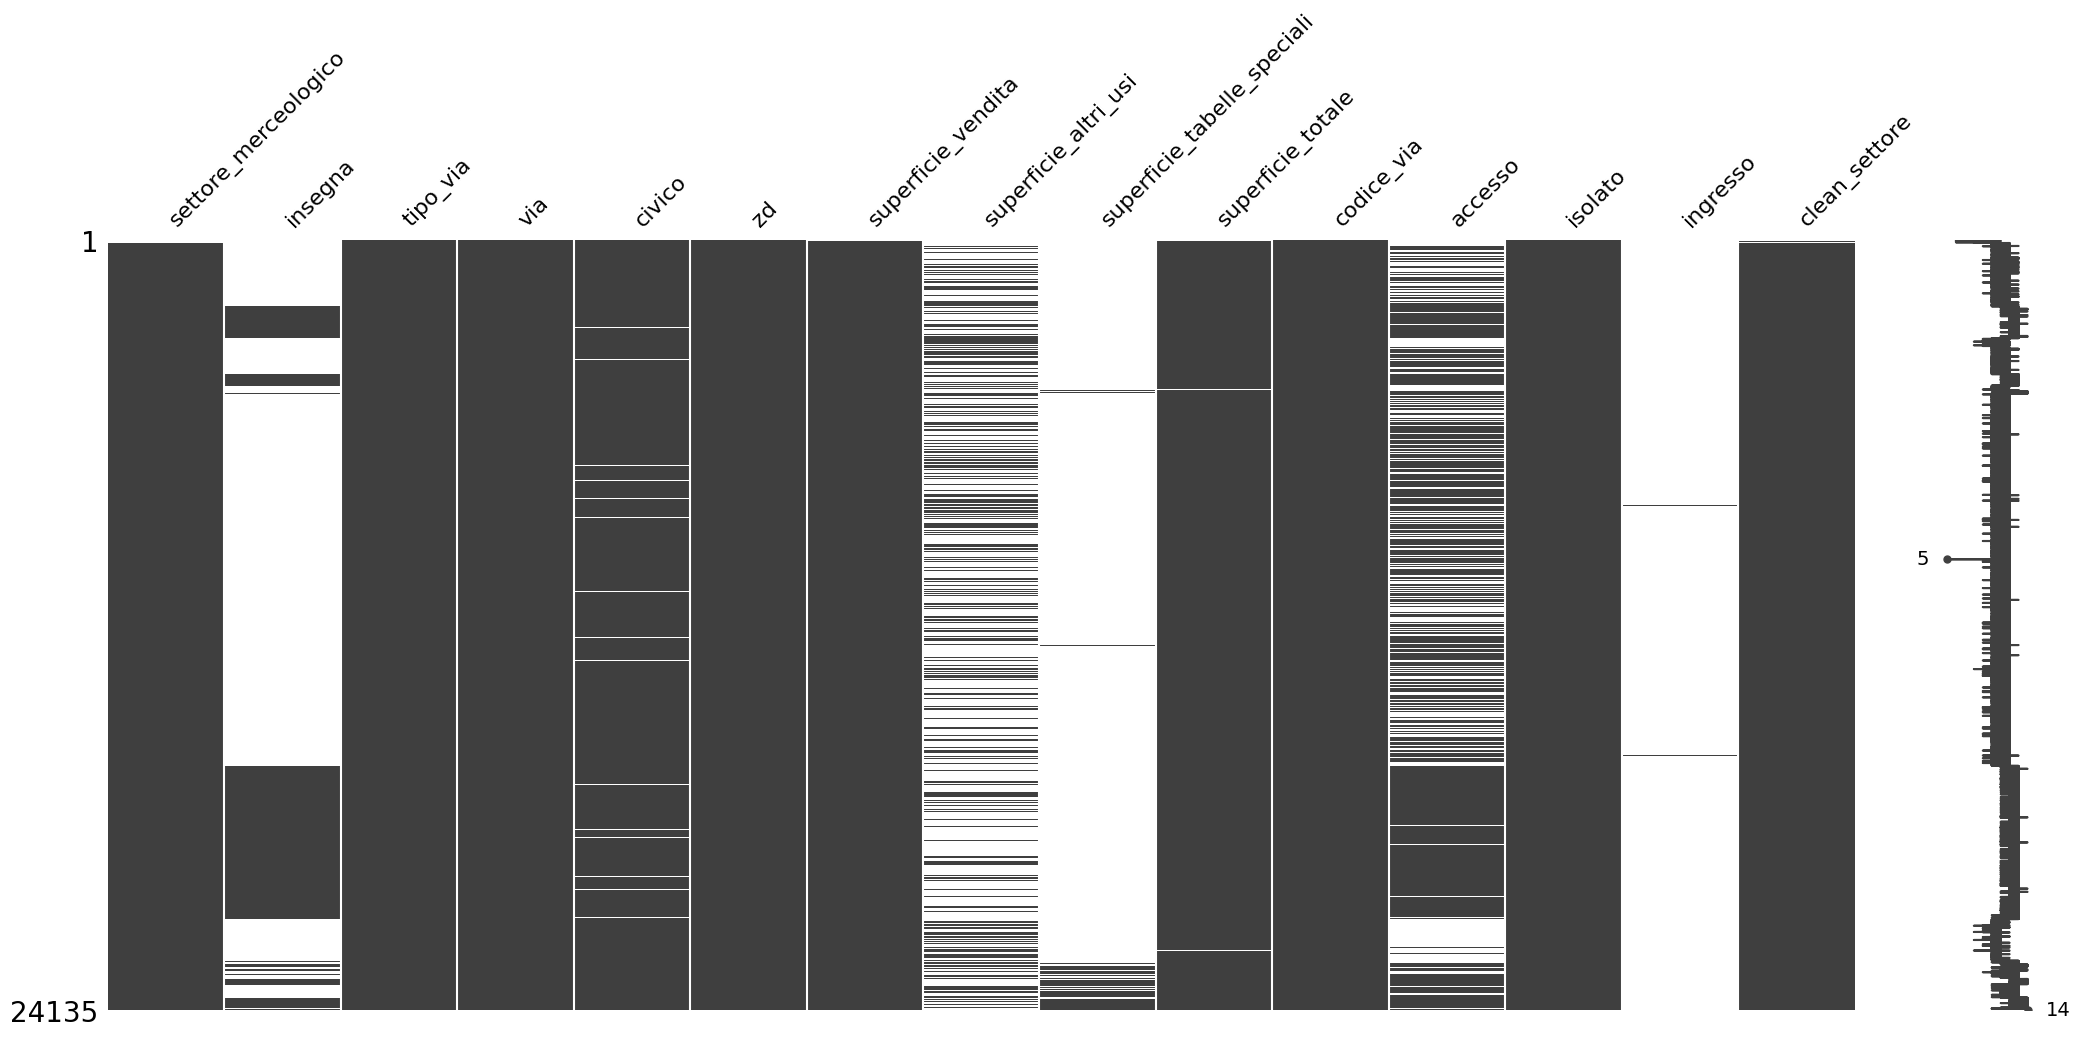

In [801]:
# Visualizing missing cells
mno.matrix(ESE)

In [802]:
# Printing the number of NULL values in each dataset column
ESE.isnull().sum()

,0
settore_merceologico,105
insegna,17147
tipo_via,0
via,0
civico,640
zd,1
superficie_vendita,29
superficie_altri_usi,15097
superficie_tabelle_speciali,23008
superficie_totale,35


Fill rows that have a NULL "***civico***" with 'S.N.C.' ('Senza Numero Civico')

In [803]:
# Fill rows that have a NULL "Civico" with 'S.N.C.' ('Senza Numero Civico')
ESE["civico"] = ESE["civico"].fillna("S.N.C.")
ESE[ESE["civico"].isnull()]

,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,clean_settore


Missing values in ***settore_prevalente*** :

In [804]:
# Missing values: settore_storico_cf_preval

# Identifica le righe con settore_storico_cf_preval mancante
mask = ESE["clean_settore"].isna()

# Si assegna un placeholder neutro per evitare imputazioni premature
ESE.loc[mask, "clean_settore"] = "SETTORE NON SPECIFICATO"

ESE["clean_settore"].isna().sum()


np.int64(0)

Missing values in ***settore_merceologico***:

In [805]:
# Missing values: settore_merceologico
mask = ESE["settore_merceologico"].isna()
ESE.loc[mask, "settore_merceologico"] = "NON SPECIFICATO"

ESE["settore_merceologico"].isna().sum()

np.int64(0)

Missing values in ***codice_via***:

In [806]:
# Visualize the record with missing codice_via
missing_codice_via = ESE.loc[ESE["codice_via"].isna()]

print(f"Number of records with missing codice_via: {len(missing_codice_via)}")
display(missing_codice_via)

Number of records with missing codice_via: 1


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,clean_settore
10007,NON ALIMENTARE,NaN,VIA,GROSOTTO,7,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NON SPECIFICATO,NaN,SETTORE NON SPECIFICATO


> Since it's an informationless record (majority of values are null) we drop it:

In [807]:
ESE = ESE.dropna(subset=["codice_via"])
ESE["codice_via"].isna().sum()

np.int64(0)

Filling other columns:

In [808]:
ESE["insegna"] = ESE["insegna"].fillna("Non specificata")
ESE["accesso"] = ESE["accesso"].fillna("Non specificato")
ESE["ingresso"] = ESE["ingresso"].fillna("Non specificato")
ESE["isolato"] = ESE["isolato"].fillna(0)
ESE.isnull().sum()

,0
settore_merceologico,0
insegna,0
tipo_via,0
via,0
civico,0
zd,0
superficie_vendita,28
superficie_altri_usi,15096
superficie_tabelle_speciali,23007
superficie_totale,34


Check ***zd*** column missing values:

In [809]:
ESE.loc[ESE["zd"].isna(), :]

,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,clean_settore


In [810]:
# Final check on overall missing values
ESE.isnull().sum()

,0
settore_merceologico,0
insegna,0
tipo_via,0
via,0
civico,0
zd,0
superficie_vendita,28
superficie_altri_usi,15096
superficie_tabelle_speciali,23007
superficie_totale,34


## **Data Deduplication - Data Fusion**

Removing redundant information (**exactly duplicated rows**)

In [811]:
# Number of exactly duplicated rows
num_duplicates = ESE.duplicated().sum()
print("Exact duplicates:", num_duplicates)

# ELIMINAZIONE
ese_dedup = ESE.drop_duplicates(keep='first').reset_index(drop=True)
print("Dataset after removing exactly duplicated rows: ", ese_dedup.shape)

Exact duplicates: 39
Dataset after removing exactly duplicated rows:  (24095, 15)


Imposing a correct value correlation in "**Superficie Totale**", as the resulting sum of  "**Superficie Vendita**", "**Superficie Altri Usi**", "**Superficie Tabelle Speciali**":


In [812]:
# Printing min and max values of 'Superficie Totale' column
print('Superficie MIN:', ese_dedup['superficie_totale'].min())
print('Superficie MAX:', ese_dedup['superficie_totale'].max())

cols_superficie = ['superficie_vendita', 'superficie_altri_usi', 'superficie_tabelle_speciali', 'superficie_totale']

print("\n Missing Values \n\n")
print(ese_dedup[cols_superficie].isnull().sum())

# Counting 0 values
num_zeri = (ese_dedup['superficie_totale'] == 0).sum()
print(f"\nValori pari a 0 in Superficie Totale: {num_zeri}")
num_zeri = (ese_dedup['superficie_vendita'] == 0).sum()
print(f"Valori pari a 0 in Superficie Vendita: {num_zeri}")
num_zeri = (ese_dedup['superficie_altri_usi'] == 0).sum()
print(f"Valori pari a 0 in Superficie Altri Usi: {num_zeri}")
num_zeri = (ese_dedup['superficie_tabelle_speciali'] == 0).sum()
print(f"Valori pari a 0 in Superficie Tabelle Speciali: {num_zeri}")


# debug to show some examples
print("\nEsempio di negozi con superficie 0:")
display(ese_dedup[ese_dedup['superficie_totale'] == 0][['insegna', 'via', 'settore_merceologico', 'superficie_totale']].head())


Superficie MIN: 0.0
Superficie MAX: 11942.0

 Missing Values 


superficie_vendita                28
superficie_altri_usi           15064
superficie_tabelle_speciali    22969
superficie_totale                 34
dtype: int64

Valori pari a 0 in Superficie Totale: 555
Valori pari a 0 in Superficie Vendita: 146
Valori pari a 0 in Superficie Altri Usi: 8
Valori pari a 0 in Superficie Tabelle Speciali: 0

Esempio di negozi con superficie 0:


,insegna,via,settore_merceologico,superficie_totale
0,Non specificata,ITALIA,NON SPECIFICATO,0.0
2,Non specificata,LODI,NON SPECIFICATO,0.0
4,Non specificata,SCALABRINI GIOVANNI BATTISTA,NON SPECIFICATO,0.0
9,Non specificata,SANTA MARIA DELLE GRAZIE,NON SPECIFICATO,0.0
11,Non specificata,ABBA GIUSEPPE CESARE,NON SPECIFICATO,0.0


In [813]:
ese_check = ese_dedup[cols_superficie].fillna(0)  # NaN = 0

ese_check['Somma_Calcolata'] = (ese_check['superficie_vendita'] +
                               ese_check['superficie_altri_usi'] +
                               ese_check['superficie_tabelle_speciali'])

mask_corretta = abs(ese_check['superficie_totale'] - ese_check['Somma_Calcolata']) == 0

print(f"Totale Righe: {len(ese_dedup)}")
print(f"Righe Coerenti: {mask_corretta.sum()}")
print(f"Righe Incoerenti: {(~mask_corretta).sum()}")

# debug
df_errori = ese_check[~mask_corretta]
print("\nEsempio di errori:")
display(df_errori.head())

Totale Righe: 24095
Righe Coerenti: 18990
Righe Incoerenti: 5105

Esempio di errori:


,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,Somma_Calcolata
6,3.0,0.0,0.0,40.0,3.0
10,10.0,0.0,10.0,70.0,20.0
43,2.0,0.0,0.0,250.0,2.0
61,115.0,0.0,0.0,190.0,115.0
74,54.0,0.0,0.0,164.0,54.0


> Since the majority of rows show "Superficie Totale" as the sum between "Superficie Vendita", "Superficie Altri Usi" and "Superficie Tabelle Speciali", we have decided to apply this rule for the entire "Superficie Totale" column, thus respecting the dataset overall coherence:

In [814]:
# Interested Columns:
cols_parti = ['superficie_vendita', 'superficie_altri_usi', 'superficie_tabelle_speciali']
col_totale = 'superficie_totale'

# To be able to perform mathematical calculations on the entire dataset, we assume that NaN means 0 square meters
cols_tutte = cols_parti + [col_totale]
ese_dedup[cols_tutte] = ese_dedup[cols_tutte].fillna(0)

# GLOBAL RECALCULATION : let's recalculate the Total for EVERY row
ese_dedup[col_totale] = ese_dedup[cols_parti].sum(axis=1)

print("Total recalculated for the entire dataset.")

check_mismatch = (abs(ese_dedup[col_totale] - ese_dedup[cols_parti].sum(axis=1)) > 0).sum()
print(f"\nFinal check, number of inconsistencies: {check_mismatch}")

# debug:
print("Clear data example:")
display(ese_dedup[cols_tutte].sample(5))

Total recalculated for the entire dataset.

Final check, number of inconsistencies: 0
Clear data example:


,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale
9196,47.0,2.0,0.0,49.0
743,200.0,0.0,0.0,200.0
19190,130.0,0.0,0.0,130.0
1997,38.0,207.0,0.0,245.0
7287,33.0,0.0,0.0,33.0


**Fixing values in columns "Settore Merceologico" and "Settore Storico Cf Prevalente"**

> Let's see what's inside "Settore Merceologico":

In [815]:
# Let's see what's inside "Settore Merceologico" - to show that it's a mess:
print(ese_dedup['settore_merceologico'].value_counts())

settore_merceologico
NON ALIMENTARE                                                                      17780
ALIMENTARE                                                                           3324
ALIMENTARE;NON ALIMENTARE                                                            1281
TABELLA SPECIALE MONOPOLIO                                                            791
TABELLA SPECIALE FARMACIE                                                             287
TABELLA SPECIALE CARBURANTI                                                           138
NON ALIMENTARE;TABELLA SPECIALE MONOPOLIO                                             129
NON ALIMENTARE;TABELLA SPECIALE FARMACIE                                              107
NON SPECIFICATO                                                                       105
ALIMENTARE;TABELLA SPECIALE MONOPOLIO                                                  47
ALIMENTARE;NON ALIMENTARE;TABELLA SPECIALE MONOPOLIO                           

> Let's show the existing *uncorrect* correlations between "Settore Merceologico" and "Settore Storico Cf Preval" columns:

In [816]:
# COHERENCE ANALISYS SECTORS "Settore Merceologico" e "Settore Storico Cf Preval"
analisi_coerenza = pd.crosstab(
    index=ese_dedup['settore_merceologico'],
    columns=ese_dedup['clean_settore'].fillna('MANCANTE'),
    margins=True,
    margins_name="Totale"
)


print("Analisi incrociata: Settore Merceologico vs Settore Storico")
print("-" * 60)

for settore_macro in analisi_coerenza.index:
    if settore_macro == "Totale": continue

    print(f"\nMACRO-SETTORE: '{settore_macro.upper()}'")


    dettagli = analisi_coerenza.loc[settore_macro]
    dettagli_presenti = dettagli[dettagli > 0].sort_values(ascending=False)

    # sottosettori trovati
    for storico, conteggio in dettagli_presenti.items():
        if storico == "Totale": continue
        print(f"   -> {conteggio:5d} righe sono '{storico}'")


Analisi incrociata: Settore Merceologico vs Settore Storico
------------------------------------------------------------

MACRO-SETTORE: 'ALIMENTARE'
   ->   330 righe sono 'PANETTERIA'
   ->   325 righe sono 'PANIFICIO CON FORNO'
   ->   253 righe sono 'MACELLERIA'
   ->   215 righe sono 'LATTERIA'
   ->   183 righe sono 'BIBITE E BEVANDE ANALCOLICHE'
   ->   159 righe sono 'FRUTTA VERDURA E FUNGHI'
   ->   153 righe sono 'SALUMERIA ROSTICCERIA CIBI'
   ->   129 righe sono 'PASTICCERIA'
   ->   118 righe sono 'VINI OLII E LIQUORI IN RECIP'
   ->   103 righe sono 'COMMERCIO AL DETTAGLIO'
   ->   102 righe sono 'BAR'
   ->    97 righe sono 'MINIMERCATI'
   ->    60 righe sono 'SALUMERIA'
   ->    57 righe sono 'PASTICCERIA GELATERIA'
   ->    53 righe sono 'GELATERIA'
   ->    48 righe sono 'ROSTICCERIA'
   ->    46 righe sono 'MACELLERIA ISLAMICA'
   ->    44 righe sono 'BIBITE'
   ->    42 righe sono 'DROGHERIA'
   ->    37 righe sono 'CAFFE CRUDO E TORREFATTO'
   ->    35 righe sono 

> Let's adjust categories in "**Settore Storico Cf Preval**", since many of them refer to the same macroarea.

> The following block focuses on lexical normalization and similarity-based deduplication.
Common abbreviations were systematically expanded (e.g. "art." in "articoli"; "x" in "per"), in order to improve lexical consistency before similarity matching and semantic categorization.

In [817]:
COL = "clean_settore"
JARO_THRESHOLD = 0.88                 # soglia per clustering intra-bucket (dedup label)
JW_FALLBACK_THRESHOLD = 0.92          # soglia per fallback verso label più vicina
TOP_CANDIDATES = 250
BLOCK_LEN = 4                         # blocking su prefisso per fallback


ABBREVIATIONS = {
    r"\bx\b": "per", r"\bx\.?\b": "per",
    r"\bart\b": "articoli", r"\bart\.\b": "articoli",
    r"\balim\b": "alimentari", r"\baliment\b": "alimentari",
    r"\bprod\b": "prodotti",
    r"\bapp\b": "apparecchiature", r"\bapparecch\b": "apparecchiature",
    r"\belettrodom\b": "elettrodomestici",
    r"\bsw\b": "software",
}

PLACEHOLDERS = { "NON SPECIFICATO", "SETTORE NON SPECIFICATO"}

def expand_abbreviations(s: str) -> str:
    if s is None:
        return s
    for pattern, repl in ABBREVIATIONS.items():
        s = re.sub(pattern, repl, s)
    return s

def normalize_text(x: object) -> str:
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()

    # remove accents
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))

    # expand abbreviations
    s = expand_abbreviations(s)

    # remove parentheses
    s = re.sub(r"\(.*?\)", " ", s)

    # keep only letters/numbers/spaces
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s if s else np.nan


# Normalize:
ese_dedup["settore_norm"] = ese_dedup[COL].apply(normalize_text)
# Neutral placeholders are excluded to avoid creating artificial clusters from "missing" labels:
mask_valid = (
    ese_dedup["settore_norm"].notna() &
    ~ese_dedup["settore_norm"].str.upper().isin(PLACEHOLDERS)
)

# frequenze su settore_norm
freq = ese_dedup.loc[mask_valid, "settore_norm"].value_counts(dropna=True)
unique_vals = freq.index.tolist()

print("Cardinality raw:", ese_dedup[COL].nunique(dropna=True))
print("Cardinality normalized (valid only):", ese_dedup.loc[mask_valid, "settore_norm"].nunique(dropna=True))


buckets = {}
for v in unique_vals:
    code = jellyfish.soundex(v)
    buckets.setdefault(code, []).append(v)

parent = {v: v for v in unique_vals}
rank = {v: 0 for v in unique_vals}

def find(a):
    while parent[a] != a:
        parent[a] = parent[parent[a]]
        a = parent[a]
    return a

def union(a, b):
    ra, rb = find(a), find(b)
    if ra == rb:
        return
    if rank[ra] < rank[rb]:
        parent[ra] = rb
    elif rank[ra] > rank[rb]:
        parent[rb] = ra
    else:
        parent[rb] = ra
        rank[ra] += 1

for code, vals in buckets.items():
    m = len(vals)
    if m <= 1:
        continue
    for i in range(m):
        v1 = vals[i]
        for j in range(i + 1, m):
            v2 = vals[j]
            jw = jellyfish.jaro_winkler_similarity(v1, v2)
            if jw >= JARO_THRESHOLD:
                union(v1, v2)

clusters = {}
for v in unique_vals:
    root = find(v)
    clusters.setdefault(root, []).append(v)

canon_map = {}
for root, members in clusters.items():
    members_sorted = sorted(members, key=lambda s: (-int(freq.get(s, 0)), len(s), s))
    canonical = members_sorted[0]
    for m in members:
        canon_map[m] = canonical


ese_dedup["settore_dedup"] = ese_dedup["settore_norm"]
ese_dedup.loc[mask_valid, "settore_dedup"] = ese_dedup.loc[mask_valid, "settore_norm"].map(canon_map)

print("Cardinality dedup (valid only):", ese_dedup.loc[mask_valid, "settore_dedup"].nunique(dropna=True))
merged_clusters = sum(1 for members in clusters.values() if len(members) > 1)
print("Merged clusters (>1 label):", merged_clusters)

# Debug: dedup non deve mai produrre etichette fuori dal dominio normalizzato valido
bad = set(ese_dedup.loc[mask_valid, "settore_dedup"].dropna().unique()) - set(ese_dedup.loc[mask_valid, "settore_norm"].dropna().unique())
print("Bad labels in settore_dedup (should be empty):", sorted(list(bad))[:50])

Cardinality raw: 2069
Cardinality normalized (valid only): 2066
Cardinality dedup (valid only): 922
Merged clusters (>1 label): 145
Bad labels in settore_dedup (should be empty): []


> The following block performs a semantic categorization, mapping the cleaned labels into a reduced set of business categories:

In [818]:
BAR_PATTERNS = [
    r"\bbar\b", r"\bcaffetteria\b", r"\bpub\b", r"\bbirreria\b", r"\bsnack\b", r"\btavola\s+fredda\b",
]
TAB_PATTERNS = [
    r"\btabacc?\w*", r"\bfumator\w*", r"\bmonopolio\b", r"\bsali\s+e\s+tabacch\w*", r"\blotto\b",
    r"\bricevitor\w*", r"\bvalori\s+bollati\b", r"\bprivativa\b",
]

OTHER_RULES = [
    ("tabaccheria", TAB_PATTERNS, "or"),
    ("bar", BAR_PATTERNS, "or"),

    ("arredamento", [
        r"\bmobil\w*", r"\barred\w*", r"\bcucin\w*", r"\bdivan\w*", r"\bpoltron\w*", r"\bmaterass\w*", r"\bcomplement\w*",
    ], "or"),

    ("alimentari", [
        r"\baliment\w*", r"\bgeneri\s+aliment\w*", r"\bcib\w*", r"\bminimercat\w*", r"\bminimarket\b", r"\bmarket\b",
        r"\bsupermercat\w*", r"\blatteri\w*", r"\blatticin\w*", r"\bcasear\w*", r"\bautogrill\b",
    ], "or"),

    ("abbigliamento", [
        r"\babbigl\w*", r"\bconfez\w*", r"\bsartori\w*", r"\bboutique\b", r"\babit\w*", r"\bcamic\w*",
    ], "or"),

    ("macchine utensili e forniture industriali", [
        r"\bmacchin\w*\s+utensil\w*", r"\bmacchinar\w*\s+industr\w*",r"\barticol\w*\s+per\s+l\s*industr\w*",
        r"\bfornitur\w*\s+industr\w*", r"\battrezzatur\w*\s+industr\w*",
    ], "or"),

    ("ottica", [
        r"\bottic\w*", r"\bfoto\s+ottic\w*", r"\bfoto\w*", r"\bottica\s+articol\w*\s+scientif\w*",
        r"\bcine[\s\-]*foto[\s\-]*ottic\w*[\s\-]*art\w*[\s\-]*scientif\w*",
    ], "or"),

    ("torrefazione", [r"\bcaff[eè]\b"], "or"),

    ("enoteca e bevande", [
        r"\benotec\w*", r"\bvin\w*", r"\bliquor\w*", r"\bbevand\w*", r"\bbibit\w*", r"\balcol\w*",
        r"\bacet\w*", r"\bsuperalcolic\w*",
    ], "or"),

    ("ferramenta e edilizia", [
        r"\bferrament\w*", r"\bedil\w*", r"\bvernici\w*", r"\bidraulic\w*"
    ], "or"),

    ("farmacia ed erboristeria", [
        r"\bfarmac\w*", r"\berborist\w*", r"\bprodott\w*\s+natural\w*"
    ], "or"),

    ("gioielleria e orologeria", [
        r"\bgioiell\w*", r"\borolog\w*", r"\boro\b", r"\boreficeri\w*"
    ], "or"),

    ("giocattoli e modello", [
        r"\bgiocattol\w*", r"\bmodellism\w*", r"\bhobby\b", r"\bgioch\w*"
    ], "or"),

    ("oggettistica", [
        r"\barticol[io]\s+(da\s+)?regal\w*", r"\bgadget\b", r"\bregal\w*", r"\bposter\w*", r"\bbombonier\w*", r"\bcart\w*",
    ], "or"),

    ("panificio", [
        r"\bpane\b", r"\bforn\w*", r"\bpanific\w*", r"\bfocacc\w*", r"\bpizza\s+al\s+taglio\b"
    ], "or"),
]

# compile
BAR_RE = [re.compile(p, re.IGNORECASE) for p in BAR_PATTERNS]
TAB_RE = [re.compile(p, re.IGNORECASE) for p in TAB_PATTERNS]
OTHER_RE = [(cat, [re.compile(p, re.IGNORECASE) for p in pats], mode) for cat, pats, mode in OTHER_RULES]

def categorize_fixed(label):
    if pd.isna(label):
        return np.nan
    s = str(label).lower()

    # bar tabacchi = 1 match BAR + 1 match TAB
    if any(r.search(s) for r in BAR_RE) and any(r.search(s) for r in TAB_RE):
        return "bar tabacchi"

    # other rules: first match wins
    for cat, regs, mode in OTHER_RE:
        if mode == "or" and any(r.search(s) for r in regs):
            return cat

    return label

orig_upper = ese_dedup["settore_dedup"].astype("string").str.upper()
ese_dedup["settore_prevalente_regex"] = (
    ese_dedup["settore_dedup"].apply(categorize_fixed).astype("string").str.upper()
)

# righe non ricodificate
is_recoded = (ese_dedup["settore_prevalente_regex"] != orig_upper)

def block_key(s: str, n: int = BLOCK_LEN) -> str:
    s = re.sub(r"\s+", " ", str(s)).strip()
    return s[:n] if len(s) >= n else s

freq_dedup = orig_upper.value_counts(dropna=True)
anchors = freq_dedup.head(TOP_CANDIDATES).index.tolist()

anchor_buckets = {}
for a in anchors:
    anchor_buckets.setdefault(block_key(a), []).append(a)

def map_to_closest_anchor(label: object) -> object:
    if pd.isna(label):
        return np.nan
    s = str(label).upper().strip()

    candidates = anchor_buckets.get(block_key(s), anchors)

    best = s
    best_sim = -1.0
    for c in candidates:
        sim = jellyfish.jaro_winkler_similarity(s, c)
        if sim > best_sim:
            best_sim = sim
            best = c

    return best if best_sim >= JW_FALLBACK_THRESHOLD else s

ese_dedup["settore_prevalente"] = ese_dedup["settore_prevalente_regex"].copy()

mask = ~is_recoded
ese_dedup.loc[mask, "settore_prevalente"] = orig_upper[mask].apply(map_to_closest_anchor)


print("Cardinality settore_dedup:", orig_upper.nunique(dropna=True))
print("Cardinality settore_prevalente:", ese_dedup["settore_prevalente"].nunique(dropna=True))

changes = pd.DataFrame({
    "from": orig_upper[mask],
    "to": ese_dedup.loc[mask, "settore_prevalente"]
})
changes = changes[changes["from"] != changes["to"]]
print("Fallback remaps count:", len(changes))
print(changes.value_counts().head(30))

print("\nTop 60 settore_prevalente:")
print(ese_dedup["settore_prevalente"].value_counts(dropna=True).head(60))

Cardinality settore_dedup: 923
Cardinality settore_prevalente: 446
Fallback remaps count: 3
from                   to                    
COMMERIO AL DETTAGLIO  COMMERCIO AL DETTAGLIO    1
PELLICCE               PELLICCERIA               1
SCARPE E ACCESSORI     SCARPE ED ACCESSORI       1
Name: count, dtype: int64

Top 60 settore_prevalente:
settore_prevalente
ABBIGLIAMENTO                                      3350
OGGETTISTICA                                       2448
ALIMENTARI                                         1277
ARREDAMENTO                                         963
COMMERCIO AL DETTAGLIO                              835
GIOIELLERIA E OROLOGERIA                            805
PROFUMERIA                                          656
FERRAMENTA E EDILIZIA                               601
FARMACIA ED ERBORISTERIA                            591
CALZATURE                                           584
BAR TABACCHI                                        577
AUTOVEICOLI         

> Some labels may remain missing after cleaning/categorization; thus we apply a final hierarchical fallback based on settore_merceologico.


In [819]:
# Final missing handling: settore_prevalente (post-regex)
mask = ese_dedup["settore_prevalente"].isna()

ese_dedup.loc[
    mask & (ese_dedup["settore_merceologico"] == "ALIMENTARE"),
    "settore_prevalente"
] = "ALTRO ALIMENTARE"

ese_dedup.loc[
    mask & (ese_dedup["settore_merceologico"] == "NON ALIMENTARE"),
    "settore_prevalente"
] = "ALTRO NON ALIMENTARE"

ese_dedup["settore_prevalente"] = ese_dedup["settore_prevalente"].fillna("SETTORE NON SPECIFICATO")

# Check
ese_dedup["settore_prevalente"].isna().sum()


np.int64(0)

In [820]:
ese_dedup.groupby("settore_prevalente").size().sort_values(ascending=False).head(20)

,0
settore_prevalente,
ABBIGLIAMENTO,3350
OGGETTISTICA,2448
ALIMENTARI,1277
ARREDAMENTO,963
COMMERCIO AL DETTAGLIO,835
GIOIELLERIA E OROLOGERIA,805
PROFUMERIA,656
FERRAMENTA E EDILIZIA,601
FARMACIA ED ERBORISTERIA,591


> Fixing Settore Merceologico:

In [821]:
categorie_food = {
    "ALIMENTARI",
    "PANIFICIO",
    "PANETTERIA",
    "MACELLERIA",
    "SALUMERIA",
    "FRUTTA VERDURA E FUNGHI",
    "PASTICCERIA",
    "GELATERIA",
    "ROSTICCERIA",
    "DROGHERIA",
    "ENOTECA E BEVANDE",
    "BAR",
    "BAR TABACCHI",
    "TORREFAZIONE",
}

tabelle_speciali = [
    "TABELLA SPECIALE MONOPOLIO", "TABELLA SPECIALE FARMACIE",
    "TABELLA SPECIALE CARBURANTI", "AUTOMOBILI", "NON ALIMENTARE",
]

def correggi_macro_settore_prevalente(row):
    macro_orig = str(row["settore_merceologico"]).upper().strip()
    micro = str(row["settore_prevalente"]).upper().strip()

    # micro is FOOD -> macro has to be ALIMENTARE
    if micro in categorie_food:
        return "ALIMENTARE", (macro_orig != "ALIMENTARE")

    # macro is "tabella speciale"/non-food -> macro has to be NON ALIMENTARE
    if any(tab in macro_orig for tab in tabelle_speciali):
        return "NON ALIMENTARE", (macro_orig != "NON ALIMENTARE")

    #if macro_orig.startswith("ALIMENTARE"):
     #    return "ALIMENTARE", True

    return row["settore_merceologico"], False


ese_dedup["settore_merceologico_OLD"] = ese_dedup["settore_merceologico"]

risultati = ese_dedup.apply(correggi_macro_settore_prevalente, axis=1)
ese_dedup["settore_merceologico"] = [r[0] for r in risultati]
ese_dedup["Flag_Correzione"] = [r[1] for r in risultati]

print("New values for settore_merceologico column:\n")
print(ese_dedup["settore_merceologico"].value_counts(dropna=False))


New values for settore_merceologico column:

settore_merceologico
NON ALIMENTARE     18978
ALIMENTARE          5045
NON SPECIFICATO       72
Name: count, dtype: int64


**Let's show the overall columns now in dataset**

In [822]:
ese_dedup.columns

Index(['settore_merceologico', 'insegna', 'tipo_via', 'via', 'civico', 'zd',
       'superficie_vendita', 'superficie_altri_usi',
       'superficie_tabelle_speciali', 'superficie_totale', 'codice_via',
       'accesso', 'isolato', 'ingresso', 'clean_settore', 'settore_norm',
       'settore_dedup', 'settore_prevalente_regex', 'settore_prevalente',
       'settore_merceologico_OLD', 'Flag_Correzione'],
      dtype='object')

Removing redoundant columns:

In [823]:
cols_to_remove = ['settore_norm', 'settore_dedup', 'clean_settore','settore_merceologico_OLD', 'settore_prevalente_regex', 'Flag_Correzione']
ese_dedup = ese_dedup.drop(columns=cols_to_remove)
ese_dedup.columns

Index(['settore_merceologico', 'insegna', 'tipo_via', 'via', 'civico', 'zd',
       'superficie_vendita', 'superficie_altri_usi',
       'superficie_tabelle_speciali', 'superficie_totale', 'codice_via',
       'accesso', 'isolato', 'ingresso', 'settore_prevalente'],
      dtype='object')

In [824]:
ese_dedup.shape

(24095, 15)

**Handling not exactly duplicated rows:**

In [825]:
# Definizione delle colonne che identificano il locale fisico
chiave_locale = ['tipo_via', 'via', 'civico', 'codice_via', 'zd', 'isolato', 'ingresso','accesso', 'settore_merceologico', 'settore_prevalente']

# Creiamo un conteggio delle occorrenze
conteggio = ese_dedup.groupby(chiave_locale, dropna=False).size().reset_index(name='Numero_Duplicati')

# Filtriamo per vedere solo quelli che appaiono più di una volta
raddoppiati = conteggio[conteggio['Numero_Duplicati'] > 1].sort_values(by='Numero_Duplicati', ascending=False)

print(f"Ci sono {len(raddoppiati)} indirizzi che hanno più di una riga associata.")
display(raddoppiati)

Ci sono 865 indirizzi che hanno più di una riga associata.


,tipo_via,via,civico,codice_via,zd,isolato,ingresso,accesso,settore_merceologico,settore_prevalente,Numero_Duplicati
3665,PZA,WAGNER RICCARDO,4,6247,7.0,195,Non specificato,ACCESSO INTERNO,ALIMENTARE,ALIMENTARI,7
15859,VIA,QUARENGHI GIACOMO,23,7478,8.0,300,Non specificato,ACCESSO INTERNO,NON ALIMENTARE,ABBIGLIAMENTO,6
6144,VIA,CAPPELLINI ALFREDO,16,2130,2.0,069,Non specificato,ACCESSO ESTERNO,NON ALIMENTARE,ABBIGLIAMENTO,6
183,CSO,BUENOS AIRES,59,2129,3.0,NON SPECIFICATO,Non specificato,Non specificato,NON ALIMENTARE,ABBIGLIAMENTO,6
891,CSO,GENOVA,6,5164,1.0,218,Non specificato,ACCESSO ESTERNO,NON ALIMENTARE,ABBIGLIAMENTO,5
...,...,...,...,...,...,...,...,...,...,...,...
7618,VIA,DE AMICIS EDMONDO,28,574,1.0,NON SPECIFICATO,Non specificato,Non specificato,NON ALIMENTARE,COMMERCIO AL DETTAGLIO,2
7622,VIA,DE AMICIS EDMONDO,33,574,1.0,457,Non specificato,ACCESSO ESTERNO,NON ALIMENTARE,PRODOTTI PER IGIENE PERSONA CASA,2
7668,VIA,DE CASTILLIA GAETANO,24,1123,9.0,294,Non specificato,ACCESSO ESTERNO,NON ALIMENTARE,FERRAMENTA E EDILIZIA,2
7720,VIA,DE SANCTIS FRANCESCO,28,5322,5.0,029,Non specificato,ACCESSO ESTERNO,NON ALIMENTARE,CALZATURE,2


> Finding candidates with **Sorted Neighborhood**:

In [826]:
#indicizzo sulla via
indexer = recordlinkage.index.SortedNeighbourhood(on="via", window=9)
candidate_links = indexer.index(ese_dedup)
print(len(candidate_links))
candidate_links

1560211


MultiIndex([(  116,   111),
            (  117,   111),
            (  218,    15),
            (  233,   126),
            (  297,   221),
            (  310,   199),
            (  310,   200),
            (  310,   201),
            (  310,   202),
            (  310,   203),
            ...
            (24094, 11258),
            (24094, 11259),
            (24094, 11260),
            (24094, 11261),
            (24094, 11262),
            (24094, 11263),
            (24094, 11264),
            (24094, 17112),
            (24094, 21978),
            (24094, 23846)],
           length=1560211)

> Comparing candidates:

In [827]:
compare_cl = recordlinkage.Compare()

# Exact compares:
compare_cl.exact('tipo_via', 'tipo_via', label='Tipo via')
compare_cl.exact('civico', 'civico', label='Civico')
compare_cl.exact('codice_via', 'codice_via', label='Codice via')
compare_cl.exact('zd', 'zd', label='ZD')
compare_cl.exact('settore_merceologico', 'settore_merceologico', label='Settore Merceologico')
compare_cl.exact('settore_prevalente', 'settore_prevalente', label='Settore')

# Not completely exact compares:
threshold = 0.90
compare_cl.string('via', 'via', method='jarowinkler', threshold=threshold, label='Via')

features = compare_cl.compute(candidate_links, ese_dedup)
features # For each column: 1 if the condition on that column is satisfied, 0 otherwise

Tipo via  Civico  Codice via  ZD  Settore Merceologico  Settore  \
116   111           0       0           0   1                     1        1   
117   111           0       0           0   1                     1        0   
218   15            1       0           0   0                     0        0   
233   126           0       0           0   0                     1        0   
297   221           0       1           0   0                     1        0   
...               ...     ...         ...  ..                   ...      ...   
24094 11263         0       0           0   0                     1        0   
      11264         0       0           0   0                     1        0   
      17112         0       0           0   0                     1        0   
      21978         0       0           0   0                     1        0   
      23846         0       0           0   0                     0        0   

             Via  
116   111    1.0  
117   111    1.0  
218   15     0.0  
233   126    0.0  
297   221    0.0  
...          ...  
24094 11263  0.0  
      11264  0.0  
      17112  0.0  
      21978  0.0  
      23846  0.0  

[1560211 rows x 7 columns]

In [828]:
features.describe()

,Tipo via,Civico,Codice via,ZD,Settore Merceologico,Settore,Via
count,1.560211e+06,1.560211e+06,1.560211e+06,1.560211e+06,1.560211e+06,1.560211e+06,1.560211e+06
mean,7.024909e-01,3.511384e-02,3.291869e-01,4.207835e-01,6.725347e-01,5.205706e-02,3.489470e-01
std,4.571625e-01,1.840676e-01,4.699181e-01,4.936850e-01,4.692887e-01,2.221422e-01,4.766373e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [829]:
# Counting the number of tuples that satisfy certain numbers of conditions
features.sum(axis=1).value_counts().sort_index(ascending=False)

,count
7.0,2559
6.0,48199
5.0,294847
4.0,173679
3.0,116883
2.0,377783
1.0,413605
0.0,132656


In [830]:
matches = features[features.sum(axis=1) >= 7]

print(len(matches))
matches

2559


,,Tipo via,Civico,Codice via,ZD,Settore Merceologico,Settore,Via
193,192,1,1,1,1,1,1,1.0
203,200,1,1,1,1,1,1,1.0
207,199,1,1,1,1,1,1,1.0
238,235,1,1,1,1,1,1,1.0
241,235,1,1,1,1,1,1,1.0
...,...,...,...,...,...,...,...,...
24055,23484,1,1,1,1,1,1,1.0
24057,10389,1,1,1,1,1,1,1.0
24065,12851,1,1,1,1,1,1,1.0
24091,22900,1,1,1,1,1,1,1.0


In [831]:
# Creating a dataframe from the matches indexes
matching_pairs = matches.index.to_frame()
# For each index in the new dataframe created above, we print the matching rows and the numerber of conditions matched
for index in matching_pairs.head(100).index:
  num_matched_conditions = features.loc[index].sum()
  print(f"Match found between rows {index[0]} and {index[1]} (Matched conditions: {num_matched_conditions}):")
  display(ese_dedup.loc[[index[0], index[1]]])
  print()

Match found between rows 193 and 192 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
193,ALIMENTARE,Non specificata,FOR,BUONAPARTE,63,1.0,23.0,0.0,0.0,23.0,711,Non specificato,NON SPECIFICATO,Non specificato,ENOTECA E BEVANDE
192,ALIMENTARE,Non specificata,FOR,BUONAPARTE,63,1.0,35.0,0.0,0.0,35.0,711,ACCESSO ESTERNO,239,Non specificato,ENOTECA E BEVANDE



Match found between rows 203 and 200 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
203,ALIMENTARE,Non specificata,LGO,GUERRIERI GONZAGA ANSELMO,1,4.0,51.0,30.0,0.0,81.0,3371,ACCESSO INTERNO,114,Non specificato,PANETTERIA
200,ALIMENTARE,Non specificata,LGO,GUERRIERI GONZAGA ANSELMO,1,4.0,44.0,0.0,0.0,44.0,3371,ACCESSO INTERNO,114,Non specificato,PANETTERIA



Match found between rows 207 and 199 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
207,ALIMENTARE,Non specificata,LGO,GUERRIERI GONZAGA ANSELMO,1,4.0,44.0,0.0,0.0,44.0,3371,ACCESSO INTERNO,114,Non specificato,MACELLERIA
199,ALIMENTARE,Non specificata,LGO,GUERRIERI GONZAGA ANSELMO,1,4.0,88.0,25.0,0.0,113.0,3371,ACCESSO ESTERNO,114,Non specificato,MACELLERIA



Match found between rows 238 and 235 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
238,ALIMENTARE,Non specificata,PLE,FERRARA,2,4.0,53.0,3.0,0.0,56.0,4158,ACCESSO ESTERNO,125,Non specificato,ALIMENTARI
235,ALIMENTARE,Non specificata,PLE,FERRARA,2,4.0,26.0,0.0,0.0,26.0,4158,ACCESSO INTERNO,125,Non specificato,ALIMENTARI



Match found between rows 241 and 235 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
241,ALIMENTARE,Non specificata,PLE,FERRARA,2,4.0,27.0,0.0,0.0,27.0,4158,ACCESSO INTERNO,125,Non specificato,ALIMENTARI
235,ALIMENTARE,Non specificata,PLE,FERRARA,2,4.0,26.0,0.0,0.0,26.0,4158,ACCESSO INTERNO,125,Non specificato,ALIMENTARI



Match found between rows 241 and 238 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
241,ALIMENTARE,Non specificata,PLE,FERRARA,2,4.0,27.0,0.0,0.0,27.0,4158,ACCESSO INTERNO,125,Non specificato,ALIMENTARI
238,ALIMENTARE,Non specificata,PLE,FERRARA,2,4.0,53.0,3.0,0.0,56.0,4158,ACCESSO ESTERNO,125,Non specificato,ALIMENTARI



Match found between rows 251 and 250 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
251,ALIMENTARE,Non specificata,PLE,LAGOSTA,7,9.0,27.0,0.0,0.0,27.0,1155,ACCESSO INTERNO,NON SPECIFICATO,Non specificato,FRUTTA VERDURA E FUNGHI
250,ALIMENTARE,Non specificata,PLE,LAGOSTA,7,9.0,24.0,0.0,0.0,24.0,1155,ACCESSO INTERNO,NON SPECIFICATO,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 252 and 249 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
252,ALIMENTARE,Non specificata,PLE,LAGOSTA,7,9.0,29.0,0.0,0.0,29.0,1155,ACCESSO INTERNO,NON SPECIFICATO,Non specificato,ALIMENTARI
249,ALIMENTARE,Non specificata,PLE,LAGOSTA,7,9.0,14.0,2.0,0.0,16.0,1155,ACCESSO ESTERNO,NON SPECIFICATO,Non specificato,ALIMENTARI



Match found between rows 256 and 248 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
256,ALIMENTARE,Non specificata,PLE,LAGOSTA,7,9.0,15.0,0.0,0.0,15.0,1155,Non specificato,NON SPECIFICATO,Non specificato,MACELLERIA
248,ALIMENTARE,Non specificata,PLE,LAGOSTA,7,9.0,32.0,0.0,0.0,32.0,1155,ACCESSO ESTERNO,NON SPECIFICATO,Non specificato,MACELLERIA



Match found between rows 261 and 260 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
261,ALIMENTARE,Non specificata,PLE,MARTINI FERDINANDO,1,4.0,150.0,0.0,0.0,150.0,3219,ACCESSO ESTERNO,063,Non specificato,ENOTECA E BEVANDE
260,ALIMENTARE,Non specificata,PLE,MARTINI FERDINANDO,1,4.0,6.0,0.0,0.0,6.0,3219,ACCESSO ESTERNO,063,Non specificato,ENOTECA E BEVANDE



Match found between rows 329 and 328 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
329,ALIMENTARE,Non specificata,PZA,PASOLINI GIUSEPPE,2,9.0,2.0,0.0,0.0,2.0,1327,Non specificato,NON SPECIFICATO,Non specificato,ENOTECA E BEVANDE
328,ALIMENTARE,Non specificata,PZA,PASOLINI GIUSEPPE,2,9.0,21.0,0.0,0.0,21.0,1327,ACCESSO ESTERNO,157,Non specificato,ENOTECA E BEVANDE



Match found between rows 334 and 333 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
334,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,12.0,0.0,0.0,12.0,7300,ACCESSO INTERNO,281,Non specificato,MACELLERIA
333,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,24.0,4.0,0.0,28.0,7300,ACCESSO INTERNO,281,Non specificato,MACELLERIA



Match found between rows 335 and 332 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
335,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,23.0,4.0,0.0,27.0,7300,ACCESSO INTERNO,281,Non specificato,ALIMENTARI
332,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,11.0,0.0,0.0,11.0,7300,ACCESSO INTERNO,281,Non specificato,ALIMENTARI



Match found between rows 336 and 332 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
336,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,13.0,0.0,0.0,13.0,7300,ACCESSO ESTERNO,281,Non specificato,ALIMENTARI
332,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,11.0,0.0,0.0,11.0,7300,ACCESSO INTERNO,281,Non specificato,ALIMENTARI



Match found between rows 336 and 335 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
336,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,13.0,0.0,0.0,13.0,7300,ACCESSO ESTERNO,281,Non specificato,ALIMENTARI
335,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,23.0,4.0,0.0,27.0,7300,ACCESSO INTERNO,281,Non specificato,ALIMENTARI



Match found between rows 337 and 332 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
337,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,29.0,5.0,0.0,34.0,7300,ACCESSO ESTERNO,281,Non specificato,ALIMENTARI
332,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,11.0,0.0,0.0,11.0,7300,ACCESSO INTERNO,281,Non specificato,ALIMENTARI



Match found between rows 337 and 335 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
337,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,29.0,5.0,0.0,34.0,7300,ACCESSO ESTERNO,281,Non specificato,ALIMENTARI
335,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,23.0,4.0,0.0,27.0,7300,ACCESSO INTERNO,281,Non specificato,ALIMENTARI



Match found between rows 337 and 336 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
337,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,29.0,5.0,0.0,34.0,7300,ACCESSO ESTERNO,281,Non specificato,ALIMENTARI
336,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,13.0,0.0,0.0,13.0,7300,ACCESSO ESTERNO,281,Non specificato,ALIMENTARI



Match found between rows 338 and 333 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
338,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,14.0,0.0,0.0,14.0,7300,ACCESSO ESTERNO,281,Non specificato,MACELLERIA
333,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,24.0,4.0,0.0,28.0,7300,ACCESSO INTERNO,281,Non specificato,MACELLERIA



Match found between rows 338 and 334 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
338,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,14.0,0.0,0.0,14.0,7300,ACCESSO ESTERNO,281,Non specificato,MACELLERIA
334,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,12.0,0.0,0.0,12.0,7300,ACCESSO INTERNO,281,Non specificato,MACELLERIA



Match found between rows 340 and 339 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
340,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,12.0,0.0,0.0,12.0,7300,ACCESSO ESTERNO,281,Non specificato,PANETTERIA
339,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,10.0,90.0,0.0,100.0,7300,ACCESSO ESTERNO,281,Non specificato,PANETTERIA



Match found between rows 344 and 331 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
344,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,38.0,0.0,0.0,38.0,7300,ACCESSO INTERNO,281,Non specificato,FRUTTA VERDURA E FUNGHI
331,ALIMENTARE,Non specificata,PZA,PREALPI,1,8.0,30.0,8.0,0.0,38.0,7300,ACCESSO INTERNO,281,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 358 and 357 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
358,ALIMENTARE,Non specificata,PZA,SAN MATERNO,8,3.0,20.0,0.0,0.0,20.0,2423,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
357,ALIMENTARE,Non specificata,PZA,SAN MATERNO,8,3.0,50.0,0.0,0.0,50.0,2423,Non specificato,012,Non specificato,ALIMENTARI



Match found between rows 385 and 384 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
385,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,10.0,0.0,19.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI
384,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,2.0,0.0,11.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 387 and 386 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
387,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,37.0,0.0,0.0,37.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA
386,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,22.0,0.0,0.0,22.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA



Match found between rows 390 and 389 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
390,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,18.0,0.0,0.0,18.0,5200,ACCESSO INTERNO,052,Non specificato,SALUMERIA
389,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,18.0,8.0,0.0,26.0,5200,ACCESSO INTERNO,052,Non specificato,SALUMERIA



Match found between rows 392 and 384 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
392,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,3.0,0.0,12.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI
384,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,2.0,0.0,11.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 392 and 385 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
392,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,3.0,0.0,12.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI
385,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,10.0,0.0,19.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 393 and 386 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
393,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,28.0,0.0,0.0,28.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA
386,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,22.0,0.0,0.0,22.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA



Match found between rows 393 and 387 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
393,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,28.0,0.0,0.0,28.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA
387,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,37.0,0.0,0.0,37.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA



Match found between rows 395 and 386 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
395,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,19.0,0.0,0.0,19.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA
386,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,22.0,0.0,0.0,22.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA



Match found between rows 395 and 387 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
395,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,19.0,0.0,0.0,19.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA
387,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,37.0,0.0,0.0,37.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA



Match found between rows 395 and 393 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
395,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,19.0,0.0,0.0,19.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA
393,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,28.0,0.0,0.0,28.0,5200,ACCESSO INTERNO,052,Non specificato,MACELLERIA



Match found between rows 396 and 384 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
396,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,11.0,0.0,20.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI
384,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,2.0,0.0,11.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 396 and 385 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
396,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,11.0,0.0,20.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI
385,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,10.0,0.0,19.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 396 and 392 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
396,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,11.0,0.0,20.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI
392,ALIMENTARE,Non specificata,PZA,VENTIQUATTRO MAGGIO,1,5.0,9.0,3.0,0.0,12.0,5200,ACCESSO INTERNO,052,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 401 and 400 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
401,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,S.N.C.,7.0,20.0,0.0,0.0,20.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
400,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,S.N.C.,7.0,15.0,0.0,15.0,30.0,6247,ACCESSO ESTERNO,195,Non specificato,ALIMENTARI



Match found between rows 402 and 400 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
402,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,S.N.C.,7.0,21.0,3.0,0.0,24.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
400,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,S.N.C.,7.0,15.0,0.0,15.0,30.0,6247,ACCESSO ESTERNO,195,Non specificato,ALIMENTARI



Match found between rows 402 and 401 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
402,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,S.N.C.,7.0,21.0,3.0,0.0,24.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
401,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,S.N.C.,7.0,20.0,0.0,0.0,20.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI



Match found between rows 412 and 411 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
412,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,24.0,2.0,12.0,38.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
411,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,11.0,2.0,0.0,13.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI



Match found between rows 414 and 413 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
414,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,26.0,7.0,0.0,33.0,6247,ACCESSO INTERNO,195,Non specificato,MACELLERIA
413,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,14.0,6.0,0.0,20.0,6247,ACCESSO INTERNO,195,Non specificato,MACELLERIA



Match found between rows 415 and 413 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
415,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,36.0,0.0,0.0,36.0,6247,ACCESSO INTERNO,195,Non specificato,MACELLERIA
413,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,14.0,6.0,0.0,20.0,6247,ACCESSO INTERNO,195,Non specificato,MACELLERIA



Match found between rows 415 and 414 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
415,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,36.0,0.0,0.0,36.0,6247,ACCESSO INTERNO,195,Non specificato,MACELLERIA
414,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,26.0,7.0,0.0,33.0,6247,ACCESSO INTERNO,195,Non specificato,MACELLERIA



Match found between rows 421 and 411 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
421,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,28.0,19.0,0.0,47.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
411,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,11.0,2.0,0.0,13.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI



Match found between rows 421 and 412 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
421,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,28.0,19.0,0.0,47.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
412,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,24.0,2.0,12.0,38.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI



Match found between rows 422 and 411 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
422,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,12.0,3.0,0.0,15.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
411,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,11.0,2.0,0.0,13.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI



Match found between rows 422 and 412 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
422,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,12.0,3.0,0.0,15.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
412,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,24.0,2.0,12.0,38.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI



Match found between rows 422 and 421 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
422,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,12.0,3.0,0.0,15.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI
421,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,28.0,19.0,0.0,47.0,6247,ACCESSO INTERNO,195,Non specificato,ALIMENTARI



Match found between rows 423 and 409 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
423,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,27.0,0.0,0.0,27.0,6247,ACCESSO INTERNO,195,Non specificato,DROGHERIA
409,ALIMENTARE,Non specificata,PZA,WAGNER RICCARDO,4,7.0,16.0,0.0,0.0,16.0,6247,ACCESSO INTERNO,195,Non specificato,DROGHERIA



Match found between rows 426 and 425 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
426,ALIMENTARE,Non specificata,RIP,DI PTA TICINESE,13,6.0,20.0,18.0,0.0,38.0,5150,Non specificato,NON SPECIFICATO,Non specificato,ENOTECA E BEVANDE
425,ALIMENTARE,Non specificata,RIP,DI PTA TICINESE,13,6.0,14.0,0.0,0.0,14.0,5150,ACCESSO ESTERNO,074,Non specificato,ENOTECA E BEVANDE



Match found between rows 430 and 429 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
430,ALIMENTARE,Non specificata,RIP,DI PTA TICINESE,49,6.0,13.0,14.0,0.0,27.0,5150,Non specificato,072,Non specificato,ENOTECA E BEVANDE
429,ALIMENTARE,Non specificata,RIP,DI PTA TICINESE,49,6.0,3.0,27.0,0.0,30.0,5150,ACCESSO ESTERNO,072,Non specificato,ENOTECA E BEVANDE



Match found between rows 498 and 219 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
498,ALIMENTARE,Non specificata,VIA,BANDELLO MATTEO,1,1.0,28.0,0.0,0.0,28.0,6214,ACCESSO ESTERNO,144,Non specificato,PASTICCERIA
219,ALIMENTARE,Non specificata,VIA,BANDELLO MATTEO,1,1.0,100.0,0.0,0.0,100.0,6214,ACCESSO INTERNO,998,Non specificato,PASTICCERIA



Match found between rows 512 and 511 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
512,ALIMENTARE,Non specificata,VIA,BASSO LELIO,8,5.0,19.0,34.0,0.0,53.0,5453,ACCESSO INTERNO,111,Non specificato,MACELLERIA
511,ALIMENTARE,Non specificata,VIA,BASSO LELIO,8,5.0,81.0,0.0,0.0,81.0,5453,ACCESSO INTERNO,111,Non specificato,MACELLERIA



Match found between rows 534 and 532 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
534,ALIMENTARE,Non specificata,VIA,BENELLI SEM,11,8.0,26.0,24.0,0.0,50.0,7497,ACCESSO ESTERNO,064,Non specificato,ALIMENTARI
532,ALIMENTARE,Non specificata,VIA,BENELLI SEM,11,8.0,32.0,12.0,0.0,44.0,7497,ACCESSO ESTERNO,064,Non specificato,ALIMENTARI



Match found between rows 610 and 609 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
610,ALIMENTARE,Non specificata,VIA,CAGLIERO GIOVANNI,9,2.0,22.0,15.0,0.0,37.0,1407,ACCESSO ESTERNO,126,Non specificato,ALIMENTARI
609,ALIMENTARE,Non specificata,VIA,CAGLIERO GIOVANNI,9,2.0,36.0,0.0,0.0,36.0,1407,ACCESSO ESTERNO,126,Non specificato,ALIMENTARI



Match found between rows 617 and 616 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
617,ALIMENTARE,Non specificata,VIA,CALVAIRATE,1,4.0,30.0,20.0,0.0,50.0,3225,ACCESSO ESTERNO,086,Non specificato,ALIMENTARI
616,ALIMENTARE,Non specificata,VIA,CALVAIRATE,1,4.0,5.0,0.0,0.0,5.0,3225,Non specificato,085,Non specificato,ALIMENTARI



Match found between rows 771 and 770 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
771,ALIMENTARE,Non specificata,VIA,DEI PANIGAROLA,2,4.0,44.0,0.0,0.0,44.0,4284,ACCESSO ESTERNO,126,Non specificato,ALIMENTARI
770,ALIMENTARE,Non specificata,VIA,DEI PANIGAROLA,2,4.0,15.0,15.0,0.0,30.0,4284,ACCESSO ESTERNO,126,Non specificato,ALIMENTARI



Match found between rows 804 and 800 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
804,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,12.0,0.0,0.0,12.0,6643,ACCESSO INTERNO,148,Non specificato,MACELLERIA
800,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,17.0,0.0,0.0,17.0,6643,ACCESSO ESTERNO,148,Non specificato,MACELLERIA



Match found between rows 805 and 800 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
805,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,16.0,12.0,0.0,28.0,6643,ACCESSO INTERNO,148,Non specificato,MACELLERIA
800,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,17.0,0.0,0.0,17.0,6643,ACCESSO ESTERNO,148,Non specificato,MACELLERIA



Match found between rows 805 and 804 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
805,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,16.0,12.0,0.0,28.0,6643,ACCESSO INTERNO,148,Non specificato,MACELLERIA
804,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,12.0,0.0,0.0,12.0,6643,ACCESSO INTERNO,148,Non specificato,MACELLERIA



Match found between rows 806 and 803 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
806,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,16.0,2.0,0.0,18.0,6643,ACCESSO INTERNO,148,Non specificato,ALIMENTARI
803,ALIMENTARE,Non specificata,VIA,DELLE FORZE ARMATE,361,7.0,16.0,4.0,0.0,20.0,6643,ACCESSO INTERNO,148,Non specificato,ALIMENTARI



Match found between rows 863 and 861 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
863,ALIMENTARE,Non specificata,VIA,FACCHINETTI CIPRIANO,2,4.0,2.0,0.0,0.0,2.0,3365,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
861,ALIMENTARE,Non specificata,VIA,FACCHINETTI CIPRIANO,2,4.0,23.0,7.0,0.0,30.0,3365,ACCESSO ESTERNO,039,Non specificato,ALIMENTARI



Match found between rows 877 and 876 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
877,ALIMENTARE,Non specificata,VIA,FARINI CARLO,74,9.0,18.0,0.0,0.0,18.0,1114,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
876,ALIMENTARE,Non specificata,VIA,FARINI CARLO,74,9.0,25.0,10.0,0.0,35.0,1114,ACCESSO ESTERNO,161,Non specificato,ALIMENTARI



Match found between rows 904 and 901 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
904,ALIMENTARE,Non specificata,VIA,F.LLI ANTONA TRAVERSI,19,8.0,43.0,20.0,0.0,63.0,7354,ACCESSO INTERNO,060,Non specificato,MACELLERIA
901,ALIMENTARE,Non specificata,VIA,F.LLI ANTONA TRAVERSI,19,8.0,36.0,51.0,0.0,87.0,7354,ACCESSO INTERNO,060,Non specificato,MACELLERIA



Match found between rows 909 and 907 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
909,ALIMENTARE,Non specificata,VIA,F.LLI ANTONA TRAVERSI,19,8.0,38.0,0.0,0.0,38.0,7354,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
907,ALIMENTARE,Non specificata,VIA,F.LLI ANTONA TRAVERSI,19,8.0,38.0,0.0,0.0,38.0,7354,ACCESSO INTERNO,060,Non specificato,ALIMENTARI



Match found between rows 939 and 938 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
939,ALIMENTARE,Non specificata,VIA,GARIGLIANO,12,9.0,20.0,0.0,0.0,20.0,1134,Non specificato,NON SPECIFICATO,Non specificato,ENOTECA E BEVANDE
938,ALIMENTARE,Non specificata,VIA,GARIGLIANO,12,9.0,3.0,0.0,0.0,3.0,1134,ACCESSO ESTERNO,278,Non specificato,ENOTECA E BEVANDE



Match found between rows 948 and 40 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
948,ALIMENTARE,Non specificata,VIA,GIAMBELLINO,155,6.0,45.0,0.0,0.0,45.0,5136,ACCESSO ESTERNO,157,Non specificato,PANIFICIO
40,ALIMENTARE,Non specificata,VIA,GIAMBELLINO,155,6.0,0.0,0.0,0.0,0.0,5136,Non specificato,NON SPECIFICATO,Non specificato,PANIFICIO



Match found between rows 999 and 997 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
999,ALIMENTARE,Non specificata,VIA,IMBONATI CARLO,23,9.0,31.0,0.0,0.0,31.0,1311,ACCESSO ESTERNO,088,Non specificato,ALIMENTARI
997,ALIMENTARE,Non specificata,VIA,IMBONATI CARLO,23,9.0,57.0,0.0,0.0,57.0,1311,ACCESSO ESTERNO,088,Non specificato,ALIMENTARI



Match found between rows 1011 and 1010 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1011,ALIMENTARE,Non specificata,VIA,INGANNI ANGELO,40,6.0,2.0,19.0,0.0,21.0,6672,Non specificato,NON SPECIFICATO,Non specificato,ENOTECA E BEVANDE
1010,ALIMENTARE,Non specificata,VIA,INGANNI ANGELO,40,6.0,1.0,52.0,0.0,53.0,6672,Non specificato,058,Non specificato,ENOTECA E BEVANDE



Match found between rows 1061 and 1058 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1061,ALIMENTARE,Non specificata,VIA,LOMBROSO CESARE,54,4.0,10.0,2.0,0.0,12.0,3334,ACCESSO ESTERNO,091,Non specificato,ALIMENTARI
1058,ALIMENTARE,Non specificata,VIA,LOMBROSO CESARE,54,4.0,45.0,0.0,0.0,45.0,3334,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI



Match found between rows 1063 and 1058 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1063,ALIMENTARE,Non specificata,VIA,LOMBROSO CESARE,54,4.0,16.0,4.0,0.0,20.0,3334,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
1058,ALIMENTARE,Non specificata,VIA,LOMBROSO CESARE,54,4.0,45.0,0.0,0.0,45.0,3334,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI



Match found between rows 1063 and 1061 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1063,ALIMENTARE,Non specificata,VIA,LOMBROSO CESARE,54,4.0,16.0,4.0,0.0,20.0,3334,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
1061,ALIMENTARE,Non specificata,VIA,LOMBROSO CESARE,54,4.0,10.0,2.0,0.0,12.0,3334,ACCESSO ESTERNO,091,Non specificato,ALIMENTARI



Match found between rows 1075 and 1074 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1075,ALIMENTARE,Non specificata,VIA,LORENTEGGIO,177,6.0,76.0,5.0,0.0,81.0,5132,ACCESSO INTERNO,137,Non specificato,MACELLERIA
1074,ALIMENTARE,Non specificata,VIA,LORENTEGGIO,177,6.0,19.0,8.0,0.0,27.0,5132,ACCESSO ESTERNO,137,Non specificato,MACELLERIA



Match found between rows 1077 and 1076 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1077,ALIMENTARE,Non specificata,VIA,LORENTEGGIO,177,6.0,42.0,0.0,0.0,42.0,5132,ACCESSO INTERNO,137,Non specificato,PANETTERIA
1076,ALIMENTARE,Non specificata,VIA,LORENTEGGIO,177,6.0,28.0,0.0,0.0,28.0,5132,ACCESSO INTERNO,137,Non specificato,PANETTERIA



Match found between rows 1138 and 1137 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1138,ALIMENTARE,Non specificata,VIA,MAZZALI GUIDO,5,3.0,42.0,0.0,0.0,42.0,2088,ACCESSO ESTERNO,054,Non specificato,MACELLERIA
1137,ALIMENTARE,Non specificata,VIA,MAZZALI GUIDO,5,3.0,247.0,83.0,0.0,330.0,2088,ACCESSO INTERNO,054,Non specificato,MACELLERIA



Match found between rows 1145 and 1143 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1145,ALIMENTARE,Non specificata,VIA,MECENATE,2,4.0,42.0,0.0,0.0,42.0,3323,Non specificato,072,Non specificato,PANETTERIA
1143,ALIMENTARE,Non specificata,VIA,MECENATE,2,4.0,20.0,20.0,0.0,40.0,3323,ACCESSO ESTERNO,072,Non specificato,PANETTERIA



Match found between rows 1151 and 1150 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1151,ALIMENTARE,Non specificata,VIA,MEDA GIUSEPPE,37,5.0,19.0,0.0,0.0,19.0,5242,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
1150,ALIMENTARE,Non specificata,VIA,MEDA GIUSEPPE,37,5.0,20.0,15.0,0.0,35.0,5242,ACCESSO ESTERNO,003,Non specificato,ALIMENTARI



Match found between rows 1163 and 59 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1163,ALIMENTARE,Non specificata,VIA,MELZI D'ERIL FRANCESCO,3,1.0,35.0,145.0,0.0,180.0,7118,ACCESSO ESTERNO,135,Non specificato,PANIFICIO
59,ALIMENTARE,Non specificata,VIA,MELZI D'ERIL FRANCESCO,3,1.0,0.0,0.0,0.0,0.0,7118,Non specificato,NON SPECIFICATO,Non specificato,PANIFICIO



Match found between rows 1188 and 1187 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1188,ALIMENTARE,Non specificata,VIA,MONCALIERI,15,9.0,24.0,0.0,0.0,24.0,1095,ACCESSO INTERNO,128,Non specificato,MACELLERIA
1187,ALIMENTARE,Non specificata,VIA,MONCALIERI,15,9.0,39.0,0.0,0.0,39.0,1095,ACCESSO INTERNO,128,Non specificato,MACELLERIA



Match found between rows 1190 and 1189 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1190,ALIMENTARE,Non specificata,VIA,MONCALIERI,15,9.0,41.0,17.0,0.0,58.0,1095,ACCESSO INTERNO,128,Non specificato,PANETTERIA
1189,ALIMENTARE,Non specificata,VIA,MONCALIERI,15,9.0,41.0,15.0,0.0,56.0,1095,ACCESSO INTERNO,128,Non specificato,PANETTERIA



Match found between rows 1194 and 1186 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1194,ALIMENTARE,Non specificata,VIA,MONCALIERI,15,9.0,38.0,10.0,0.0,48.0,1095,ACCESSO INTERNO,128,Non specificato,ALIMENTARI
1186,ALIMENTARE,Non specificata,VIA,MONCALIERI,15,9.0,24.0,26.0,0.0,50.0,1095,ACCESSO INTERNO,128,Non specificato,ALIMENTARI



Match found between rows 1211 and 1208 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1211,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,20.0,18.0,0.0,38.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA
1208,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,26.0,0.0,0.0,26.0,5330,ACCESSO ESTERNO,036,Non specificato,MACELLERIA



Match found between rows 1212 and 1208 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1212,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,38.0,13.0,0.0,51.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA
1208,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,26.0,0.0,0.0,26.0,5330,ACCESSO ESTERNO,036,Non specificato,MACELLERIA



Match found between rows 1212 and 1211 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1212,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,38.0,13.0,0.0,51.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA
1211,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,20.0,18.0,0.0,38.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA



Match found between rows 1213 and 1208 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1213,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,20.0,0.0,0.0,20.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA
1208,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,26.0,0.0,0.0,26.0,5330,ACCESSO ESTERNO,036,Non specificato,MACELLERIA



Match found between rows 1213 and 1211 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1213,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,20.0,0.0,0.0,20.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA
1211,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,20.0,18.0,0.0,38.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA



Match found between rows 1213 and 1212 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1213,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,20.0,0.0,0.0,20.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA
1212,ALIMENTARE,Non specificata,VIA,MONTEGANI LODOVICO,33,5.0,38.0,13.0,0.0,51.0,5330,ACCESSO INTERNO,036,Non specificato,MACELLERIA



Match found between rows 1313 and 1312 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1313,ALIMENTARE,Non specificata,VIA,PADOVA,23,2.0,23.0,16.0,0.0,39.0,2275,Non specificato,352,Non specificato,ALIMENTARI
1312,ALIMENTARE,Non specificata,VIA,PADOVA,23,2.0,80.0,0.0,0.0,80.0,2275,ACCESSO ESTERNO,352,Non specificato,ALIMENTARI



Match found between rows 1414 and 1413 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1414,ALIMENTARE,Non specificata,VIA,PLINIO CAIO SECONDO,6,3.0,25.0,175.0,0.0,200.0,2144,Non specificato,061,Non specificato,PANETTERIA
1413,ALIMENTARE,Non specificata,VIA,PLINIO CAIO SECONDO,6,3.0,55.0,0.0,0.0,55.0,2144,ACCESSO ESTERNO,061,Non specificato,PANETTERIA



Match found between rows 1507 and 70 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1507,ALIMENTARE,Non specificata,VIA,RIPAMONTI GIUSEPPE,204,5.0,38.0,38.0,0.0,76.0,4066,ACCESSO ESTERNO,165,Non specificato,PANIFICIO
70,ALIMENTARE,Non specificata,VIA,RIPAMONTI GIUSEPPE,204,5.0,0.0,0.0,0.0,0.0,4066,Non specificato,NON SPECIFICATO,Non specificato,PANIFICIO



Match found between rows 1526 and 1522 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1526,ALIMENTARE,Non specificata,VIA,ROMBON,34,3.0,34.0,0.0,0.0,34.0,2659,ACCESSO INTERNO,098,Non specificato,MACELLERIA
1522,ALIMENTARE,Non specificata,VIA,ROMBON,34,3.0,35.0,26.0,0.0,61.0,2659,ACCESSO ESTERNO,098,Non specificato,MACELLERIA



Match found between rows 1566 and 1565 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1566,ALIMENTARE,Non specificata,VIA,SAN PAOLINO,2,6.0,28.0,12.0,0.0,40.0,5425,ACCESSO ESTERNO,101,Non specificato,PANETTERIA
1565,ALIMENTARE,Non specificata,VIA,SAN PAOLINO,2,6.0,20.0,40.0,0.0,60.0,5425,ACCESSO ESTERNO,101,Non specificato,PANETTERIA



Match found between rows 1599 and 1597 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1599,ALIMENTARE,Non specificata,VIA,SARPI FRA' PAOLO,8,8.0,20.0,0.0,0.0,20.0,7210,Non specificato,068,Non specificato,FRUTTA VERDURA E FUNGHI
1597,ALIMENTARE,Non specificata,VIA,SARPI FRA' PAOLO,8,8.0,20.0,0.0,0.0,20.0,7210,ACCESSO INTERNO,068,Non specificato,FRUTTA VERDURA E FUNGHI



Match found between rows 1614 and 1613 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1614,ALIMENTARE,Non specificata,VIA,SCALVINI GIOVITA,3,9.0,39.0,0.0,0.0,39.0,1265,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI
1613,ALIMENTARE,Non specificata,VIA,SCALVINI GIOVITA,3,9.0,29.0,0.0,0.0,29.0,1265,Non specificato,NON SPECIFICATO,Non specificato,ALIMENTARI



Match found between rows 1634 and 1633 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1634,ALIMENTARE,Non specificata,VIA,SFORZA ASCANIO,47,5.0,3.0,0.0,0.0,3.0,5201,Non specificato,NON SPECIFICATO,Non specificato,ENOTECA E BEVANDE
1633,ALIMENTARE,Non specificata,VIA,SFORZA ASCANIO,47,5.0,40.0,10.0,0.0,50.0,5201,ACCESSO ESTERNO,125,Non specificato,ENOTECA E BEVANDE



Match found between rows 1682 and 1681 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1682,ALIMENTARE,Non specificata,VIA,STAMIRA D'ANCONA,28,2.0,86.0,0.0,0.0,86.0,2337,Non specificato,195,Non specificato,ALIMENTARI
1681,ALIMENTARE,Non specificata,VIA,STAMIRA D'ANCONA,28,2.0,140.0,0.0,0.0,140.0,2337,ACCESSO ESTERNO,122,Non specificato,ALIMENTARI



Match found between rows 1716 and 79 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1716,ALIMENTARE,Non specificata,VIA,TIEPOLO GIAN BATTISTA,60,3.0,30.0,0.0,0.0,30.0,3126,ACCESSO ESTERNO,168,Non specificato,PANIFICIO
79,ALIMENTARE,Non specificata,VIA,TIEPOLO GIAN BATTISTA,60,3.0,0.0,0.0,0.0,0.0,3126,Non specificato,NON SPECIFICATO,Non specificato,PANIFICIO



Match found between rows 1738 and 1737 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1738,ALIMENTARE,Non specificata,VIA,TRINCEA DELLE FRASCHE,2,5.0,50.0,40.0,0.0,90.0,5173,ACCESSO ESTERNO,095,Non specificato,PASTICCERIA
1737,ALIMENTARE,Non specificata,VIA,TRINCEA DELLE FRASCHE,2,5.0,12.0,0.0,0.0,12.0,5173,ACCESSO ESTERNO,095,Non specificato,PASTICCERIA



Match found between rows 1779 and 1778 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1779,ALIMENTARE,Non specificata,VIA,VENINI GIULIO E CORRADO,26,2.0,25.0,0.0,0.0,25.0,2258,Non specificato,NON SPECIFICATO,Non specificato,ENOTECA E BEVANDE
1778,ALIMENTARE,Non specificata,VIA,VENINI GIULIO E CORRADO,26,2.0,35.0,15.0,0.0,50.0,2258,ACCESSO ESTERNO,355,Non specificato,ENOTECA E BEVANDE



Match found between rows 1810 and 1809 (Matched conditions: 7.0):


,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
1810,ALIMENTARE,Non specificata,VIA,VITTORINI ELIO,32,4.0,19.0,0.0,0.0,19.0,3379,Non specificato,126,Non specificato,MACELLERIA
1809,ALIMENTARE,Non specificata,VIA,VITTORINI ELIO,32,4.0,45.0,0.0,0.0,45.0,3379,ACCESSO ESTERNO,126,Non specificato,MACELLERIA


In [832]:
def get_row_to_drop(row1, row2):
  # Define what we consider "empty" or "bad data":
  invalid_vals = {None, "Non specificata", "Non specificato"}

  # Check 'Insegna': we want to keep the one that is NOT NaN and NOT "Non specificata"
  val1 = ese_dedup.iloc[row1]["insegna"]
  val2 = ese_dedup.iloc[row2]["insegna"]

  # Check if row1 is "worse" than row2
  row1_insegna_invalid = pd.isna(val1) or val1 in invalid_vals
  row2_insegna_invalid = pd.isna(val2) or val2 in invalid_vals

  if row1_insegna_invalid and not row2_insegna_invalid:
      return row1
  if row2_insegna_invalid and not row1_insegna_invalid:
      return row2

  # Check 'superficie_totale':
  p1 = ese_dedup.iloc[row1]["superficie_totale"]
  p2 = ese_dedup.iloc[row2]["superficie_totale"]

  if p1 == 0:
    return row1
  if p2 == 0:
    return row2

  # If both are equally good (or equally bad), drop the second one
  return row2


In [833]:
def get_gauss_score(v1, v2, scale):
    # Calculates Gaussian similarity between two numbers:
    if pd.isna(v1) or pd.isna(v2):
        return 0.0
    distance = abs(v1 - v2)
    return np.exp(-0.5 * (distance / scale)**2)

def get_jw_score(s1, s2):
    # Handle NaNs: if either is missing, similarity is 0
    if pd.isna(s1) and pd.isna(s2):
        return 1.0
    if pd.isna(s1) or pd.isna(s2):
        return 0.0
    return jellyfish.jaro_winkler_similarity(str(s1), str(s2))

In [834]:
ese_dedup_drop = ese_dedup.copy()
dropped_indexes = set()
JW_THRESHOLD = 0.85
GAUSS_THRESHOLD = 0.60   # Numerical similarity (roughly distance <= scale)
SCALE = 20

for i in matches.index:
  idx1, idx2 = i[0], i[1]

  if idx1 in dropped_indexes or idx2 in dropped_indexes:
        continue

  row1 = ese_dedup.loc[idx1]
  row2 = ese_dedup.loc[idx2]

  insegna_score = get_jw_score(row1['insegna'], row2['insegna'])
  superficie_score = get_gauss_score(row1['superficie_totale'], row2['superficie_totale'], scale=SCALE)

  # Getting the index of the row to drop
  # If insegna_score is enough we consider it a match and check which column to drop
  if insegna_score >= JW_THRESHOLD:
    row_to_drop = get_row_to_drop(idx1, idx2)

  # if insegna_score wasn't enough we check if one of the two value was NA, if so we check on superficie_totale otherwise it wasn't a match
  elif (pd.isna(row1['insegna']) or pd.isna(row2['insegna'])) and superficie_score >= GAUSS_THRESHOLD:
    row_to_drop = get_row_to_drop(idx1, idx2)


    if row_to_drop in ese_dedup_drop.index:
      ese_dedup_drop = ese_dedup_drop.drop(row_to_drop)
      dropped_indexes.add(row_to_drop)

In [835]:
ese_dedup_drop.reset_index(drop=True, inplace=True)
ese_dedup_drop

,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
0,ALIMENTARE,Non specificata,CSO,ITALIA,34,1.0,0.0,0.0,0.0,0.0,526,Non specificato,NON SPECIFICATO,Non specificato,PANIFICIO
1,NON SPECIFICATO,Non specificata,CSO,LODI,104,4.0,16.0,5.0,0.0,21.0,4068,Non specificato,NON SPECIFICATO,Non specificato,SETTORE NON SPECIFICATO
2,ALIMENTARE,Non specificata,CSO,LODI,26,5.0,0.0,0.0,0.0,0.0,4068,Non specificato,NON SPECIFICATO,Non specificato,PANIFICIO
3,NON SPECIFICATO,Non specificata,CSO,SEMPIONE,41,6.0,120.0,0.0,0.0,120.0,7137,Non specificato,NON SPECIFICATO,Non specificato,SETTORE NON SPECIFICATO
4,NON SPECIFICATO,Non specificata,LGO,SCALABRINI GIOVANNI BATTISTA,2,6.0,0.0,0.0,0.0,0.0,5392,Non specificato,NON SPECIFICATO,Non specificato,SETTORE NON SPECIFICATO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24090,NON ALIMENTARE,Non specificata,RIP,DI PTA TICINESE,61,6.0,25.0,27.0,21.0,73.0,5150,ACCESSO ESTERNO,071,Non specificato,OGGETTISTICA
24091,NON ALIMENTARE,IP,VIA,GALVANI LUIGI,34,2.0,45.0,0.0,0.0,45.0,1179,ACCESSO ESTERNO,238,Non specificato,CARBURANTI E LUBRIFICANTI
24092,NON ALIMENTARE,TABACCHI NOLI,VIA,MARINO TOMMASO,7,1.0,28.0,12.0,0.0,40.0,204,ACCESSO ESTERNO,415,Non specificato,OGGETTISTICA
24093,NON ALIMENTARE,Non specificata,VIA,ASELLI GASPARE,11,3.0,7.0,125.0,5.0,137.0,3167,Non specificato,NON SPECIFICATO,Non specificato,COMMERCIO AL DETTAGLIO


In [836]:
ese_dedup = ese_dedup_drop.copy()
ese_dedup.shape

(24095, 15)

### **Outliers Detection**

In [837]:
# Inspecting the possible columns on which we can perform Outliers detection:
columns = list(ese_dedup.columns)
types = list(ese_dedup.dtypes)
for i in range(len(columns)):
  print(f"{columns[i]} : {types[i]}")

settore_merceologico : object
insegna : object
tipo_via : object
via : object
civico : object
zd : float64
superficie_vendita : float64
superficie_altri_usi : float64
superficie_tabelle_speciali : float64
superficie_totale : float64
codice_via : Int64
accesso : object
isolato : object
ingresso : object
settore_prevalente : string


By analyzing all the columns that remained in the dataset, columns for which make sense perform an Outliers detection are the Superficie-related columns, since:
- Codice via: numeric value that is used as an identifier of the street, and therefore it does not represent a "measure" in which we can find outliers
- Isolato/Zd: numeric values that are used as an identifier of an urban area, and therefore not represent a "measure" in which we can find outliers


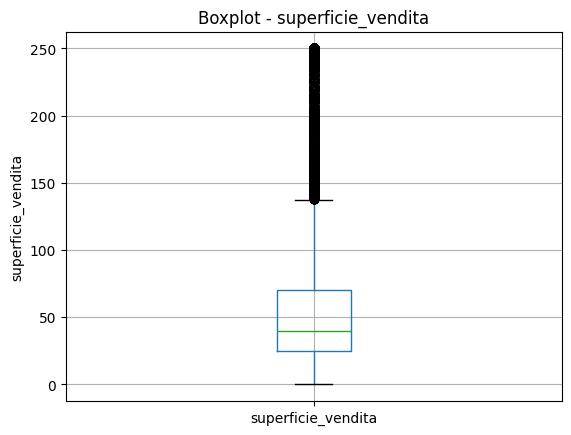

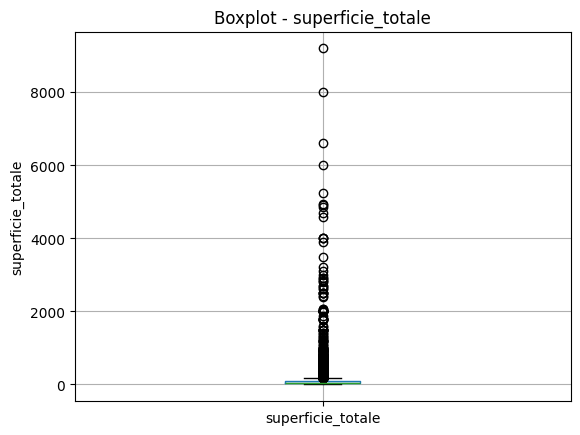

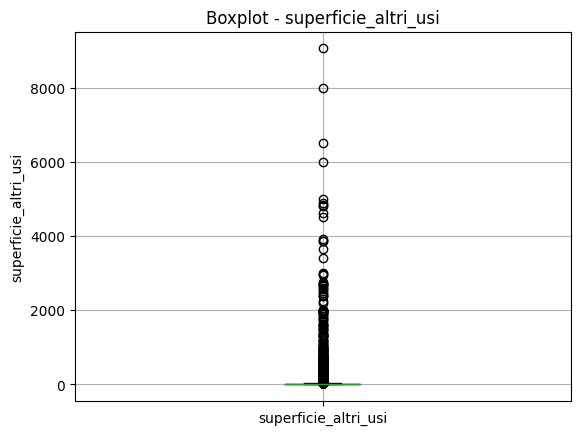

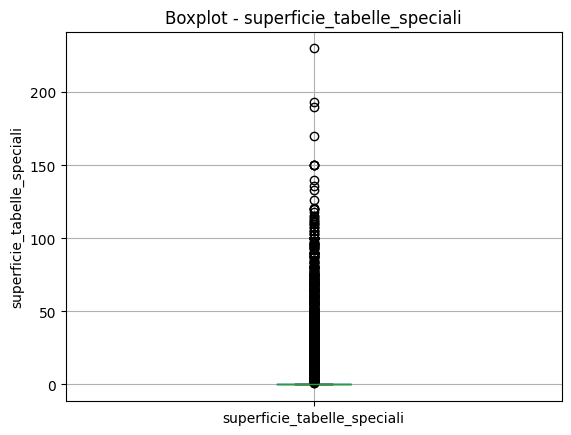

In [838]:
cols_outliers = [ "superficie_vendita", "superficie_totale", "superficie_altri_usi", "superficie_tabelle_speciali"]
for c in cols_outliers:
    plt.figure()
    ese_dedup.boxplot(column=c)
    plt.title(f"Boxplot - {c}")
    plt.ylabel(c)
    plt.show()

Outlier detection was performed using the Interquartile Range (IQR) method within each prevalent sector.
This choice was motivated by the strong heterogeneity in typical surface sizes across different commercial sectors: a value that may be considered extreme in one sector can be perfectly normal in another

In [839]:
# IQR statistics per column:
iqr_bounds = {}

for c in cols_outliers:
    s = ese_dedup[c].dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr

    iqr_bounds[c] = {"Q1": q1, "Q3": q3, "IQR": iqr, "upper": upper}

pd.DataFrame(iqr_bounds).T


,Q1,Q3,IQR,upper
superficie_vendita,25.0,70.0,45.0,137.5
superficie_totale,31.0,92.0,61.0,183.5
superficie_altri_usi,0.0,15.0,15.0,37.5
superficie_tabelle_speciali,0.0,0.0,0.0,0.0


In [840]:
# Boolean Flag for global outliers (non si rimuovono i valori, si segnano soltanto)
for c in cols_outliers:
    upper = iqr_bounds[c]["upper"]
    ese_dedup[f"flag_outlier_{c}"] = ese_dedup[c] > upper

# Counting ouliers per column:
for c in cols_outliers:
    print(c, ese_dedup[f"flag_outlier_{c}"].sum())


superficie_vendita 2021
superficie_totale 1901
superficie_altri_usi 2990
superficie_tabelle_speciali 1126


In [841]:
# Check plausible values
for c in cols_outliers:
    print(f"\nTop 15 outlier per {c}")
    display(
        ese_dedup.loc[ese_dedup[f"flag_outlier_{c}"],
                      ["settore_prevalente"] + cols_outliers]
        .sort_values(c, ascending=False)
        .head(15)
    )


Top 15 outlier per superficie_vendita


,settore_prevalente,superficie_vendita,superficie_totale,superficie_altri_usi,superficie_tabelle_speciali
3723,ABBIGLIAMENTO,250.0,250.0,0.0,0.0
22168,TEMPORARY SHOP DI CALZATURE ED ACCESSORI,250.0,250.0,0.0,0.0
2657,PESCHERIA,250.0,410.0,160.0,0.0
22492,COMMERCIO AL DETTAGLIO,250.0,250.0,0.0,0.0
9789,AUTO MOTO CICLI,250.0,250.0,0.0,0.0
9887,ANTICHITA E OGGETTI D ARTE AN,250.0,250.0,0.0,0.0
22303,COMMERCIO AL DETTAGLIO,250.0,500.0,250.0,0.0
9872,AUTOVEICOLI,250.0,250.0,0.0,0.0
15651,ABBIGLIAMENTO,250.0,250.0,0.0,0.0
10303,PNEUMATICI,250.0,500.0,250.0,0.0



Top 15 outlier per superficie_totale


,settore_prevalente,superficie_vendita,superficie_totale,superficie_altri_usi,superficie_tabelle_speciali
8776,AUTO MOTO CICLI,145.0,9201.0,9056.0,0.0
10415,ACCESSORI E RICAMBI AUTO MOTO,10.0,8000.0,7990.0,0.0
9143,AUTO MOTO CICLI,100.0,6600.0,6500.0,0.0
11656,ACCESSORI E RICAMBI AUTO MOTO,5.0,6000.0,5995.0,0.0
16791,MACCH E PRODOTTI PER AGRICOLTURA MACCHINE E PR...,250.0,5250.0,5000.0,0.0
20601,AUTO MOTO CICLI,109.0,4945.0,4836.0,0.0
8316,DISCHI,20.0,4900.0,4880.0,0.0
12011,METALSIDERURGICI,30.0,4850.0,4820.0,0.0
13860,COMBUSTIBILI,70.0,4700.0,4630.0,0.0
10152,FERRAMENTA E EDILIZIA,91.0,4591.0,4500.0,0.0



Top 15 outlier per superficie_altri_usi


,settore_prevalente,superficie_vendita,superficie_totale,superficie_altri_usi,superficie_tabelle_speciali
8776,AUTO MOTO CICLI,145.0,9201.0,9056.0,0.0
10415,ACCESSORI E RICAMBI AUTO MOTO,10.0,8000.0,7990.0,0.0
9143,AUTO MOTO CICLI,100.0,6600.0,6500.0,0.0
11656,ACCESSORI E RICAMBI AUTO MOTO,5.0,6000.0,5995.0,0.0
16791,MACCH E PRODOTTI PER AGRICOLTURA MACCHINE E PR...,250.0,5250.0,5000.0,0.0
8316,DISCHI,20.0,4900.0,4880.0,0.0
20601,AUTO MOTO CICLI,109.0,4945.0,4836.0,0.0
12011,METALSIDERURGICI,30.0,4850.0,4820.0,0.0
13860,COMBUSTIBILI,70.0,4700.0,4630.0,0.0
10152,FERRAMENTA E EDILIZIA,91.0,4591.0,4500.0,0.0



Top 15 outlier per superficie_tabelle_speciali


,settore_prevalente,superficie_vendita,superficie_totale,superficie_altri_usi,superficie_tabelle_speciali
22919,CARBURANTI E LUBRIFICANTI,230.0,460.0,0.0,230.0
4766,FARMACIA ED ERBORISTERIA,208.0,551.0,150.0,193.0
22646,FARMACIA ED ERBORISTERIA,240.0,731.0,301.0,190.0
17244,CARBURANTI E LUBRIFICANTI,175.0,345.0,0.0,170.0
23992,OGGETTISTICA,150.0,300.0,0.0,150.0
4711,ALIMENTARI,197.0,347.0,0.0,150.0
4735,FARMACIA ED ERBORISTERIA,180.0,330.0,0.0,150.0
23021,FARMACIA ED ERBORISTERIA,150.0,300.0,0.0,150.0
22718,FARMACIA ED ERBORISTERIA,140.0,280.0,0.0,140.0
23221,FARMACIA ED ERBORISTERIA,136.0,272.0,0.0,136.0


Outliers are detected using the IQR method applied separately within each *settore_prevalente*, in order to account for sector-specific differences in typical surface sizes. \
Detected outliers were flagged but not removed, as they may correspond to legitimately large commercial establishments

In [842]:
min_group_size = 30

for c in cols_outliers:
    ese_dedup[f"flag_outlier_{c}_by_settore"] = False

    for settore, g in ese_dedup.groupby("settore_prevalente"):
        s = g[c].dropna()
        if len(s) < min_group_size:
            continue

        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr

        idx = g[g[c] > upper].index
        ese_dedup.loc[idx, f"flag_outlier_{c}_by_settore"] = True

# counting:
for c in cols_outliers:
    print(c, ese_dedup[f"flag_outlier_{c}_by_settore"].sum())

superficie_vendita 1583
superficie_totale 1654
superficie_altri_usi 3094
superficie_tabelle_speciali 334


In [843]:
summary = []

for c in cols_outliers:
    n_tot = ese_dedup[c].notna().sum()
    n_out_glob = ese_dedup[f"flag_outlier_{c}"].sum()
    n_out_sett = ese_dedup[f"flag_outlier_{c}_by_settore"].sum()

    summary.append({
        "colonna": c,
        "n_non_null": n_tot,
        "outliers_IQR_global": int(n_out_glob),
        "outliers_IQR_by_settore": int(n_out_sett),
        "pct_out_global": round(100 * n_out_glob / n_tot, 3) if n_tot else np.nan,
        "pct_out_by_settore": round(100 * n_out_sett / n_tot, 3) if n_tot else np.nan
    })

pd.DataFrame(summary)

,colonna,n_non_null,outliers_IQR_global,outliers_IQR_by_settore,pct_out_global,pct_out_by_settore
0,superficie_vendita,24095,2021,1583,8.388,6.570
1,superficie_totale,24095,1901,1654,7.890,6.864
2,superficie_altri_usi,24095,2990,3094,12.409,12.841
3,superficie_tabelle_speciali,24095,1126,334,4.673,1.386


In [844]:
# Final flag finale, stating if a record is an outlier at least for one "superficie" (per settore)
outlier_flags_final = [f"flag_outlier_{c}_by_settore" for c in cols_outliers]

ese_dedup["flag_any_outlier_surface"] = (ese_dedup[outlier_flags_final].any(axis=1))

# Final distribution
ese_dedup["flag_any_outlier_surface"].value_counts()


,count
flag_any_outlier_surface,
False,19455
True,4640


Removing debug fields:

In [845]:
debug_columns = ['flag_outlier_superficie_vendita', 'flag_outlier_superficie_totale',
                 'flag_outlier_superficie_altri_usi','flag_outlier_superficie_tabelle_speciali',
                 'flag_outlier_superficie_vendita_by_settore', 'flag_outlier_superficie_totale_by_settore',
                'flag_outlier_superficie_altri_usi_by_settore', 'flag_outlier_superficie_tabelle_speciali_by_settore',
       'flag_any_outlier_surface']
ese_dedup = ese_dedup.drop(columns=debug_columns)
ese_dedup.columns

Index(['settore_merceologico', 'insegna', 'tipo_via', 'via', 'civico', 'zd',
       'superficie_vendita', 'superficie_altri_usi',
       'superficie_tabelle_speciali', 'superficie_totale', 'codice_via',
       'accesso', 'isolato', 'ingresso', 'settore_prevalente'],
      dtype='object')

### Final overall Standardization
After all steps we perform a final standardization of records:

In [846]:
# Final standardization
text_cols = ese_dedup.select_dtypes(include=["object", "string"]).columns

#convert float in int
float_cols = ese_dedup.select_dtypes(include=["float"]).columns
ese_dedup[float_cols] = ese_dedup[float_cols].astype(int)

# MAIUSC
for col in text_cols:
    ese_dedup[col] = ese_dedup[col].str.upper()

In [847]:
ese_dedup.dtypes

,0
settore_merceologico,object
insegna,object
tipo_via,object
via,object
civico,object
zd,int64
superficie_vendita,int64
superficie_altri_usi,int64
superficie_tabelle_speciali,int64
superficie_totale,int64


In [848]:
ese_dedup.head(10)

,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente
0,ALIMENTARE,NON SPECIFICATA,CSO,ITALIA,34,1,0,0,0,0,526,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,PANIFICIO
1,NON SPECIFICATO,NON SPECIFICATA,CSO,LODI,104,4,16,5,0,21,4068,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,SETTORE NON SPECIFICATO
2,ALIMENTARE,NON SPECIFICATA,CSO,LODI,26,5,0,0,0,0,4068,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,PANIFICIO
3,NON SPECIFICATO,NON SPECIFICATA,CSO,SEMPIONE,41,6,120,0,0,120,7137,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,SETTORE NON SPECIFICATO
4,NON SPECIFICATO,NON SPECIFICATA,LGO,SCALABRINI GIOVANNI BATTISTA,2,6,0,0,0,0,5392,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,SETTORE NON SPECIFICATO
5,ALIMENTARE,NON SPECIFICATA,PLE,STAZIONE DI PORTA GENOVA,2,6,36,0,0,36,5120,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,PANIFICIO
6,NON SPECIFICATO,NON SPECIFICATA,PZA,ASPROMONTE,1,3,3,0,0,3,2246,ACCESSO ESTERNO,041,NON SPECIFICATO,PRODOTTI PER IGIENE PERSONA CASA
7,NON SPECIFICATO,NON SPECIFICATA,PZA,BONOMELLI GEREMIA,10,5,14,143,0,157,4150,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,ESERCIZIO DI VICINATO
8,NON SPECIFICATO,NON SPECIFICATA,PZA,OBERDAN GUGLIELMO,2,1,190,100,0,290,2108,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,COMMERCIO AL DETTAGLIO
9,NON SPECIFICATO,NON SPECIFICATA,PZA,SANTA MARIA DELLE GRAZIE,1,1,0,0,0,0,6164,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,SETTORE NON SPECIFICATO


## **Data quality assessment (after cleaning)**

In [849]:
# Number of rows after cleaning the dataset
print(f"Number of rows after cleaning the dataset: {ese_dedup.shape[0]}")

Number of rows after cleaning the dataset: 24095


Null values

In [850]:
# Display the number of NULL values for each column
NULL_VAL_PER_COL = ese_dedup.isnull().sum()
print(f"Number of NULL values for each column:\n{NULL_VAL_PER_COL}")

Number of NULL values for each column:
settore_merceologico           0
insegna                        0
tipo_via                       0
via                            0
civico                         0
zd                             0
superficie_vendita             0
superficie_altri_usi           0
superficie_tabelle_speciali    0
superficie_totale              0
codice_via                     0
accesso                        0
isolato                        0
ingresso                       0
settore_prevalente             0
dtype: int64


Completeness evaluation

In [851]:
TOT = ese_dedup.shape[0]*ese_dedup.shape[1]
NOT_NULL = ese_dedup.count().sum()
# Computing the ratio between the number of NOT NULL cells with the total number of cells
COMPLETENESS = NOT_NULL/TOT

# Display the percentage of NOT NULL tuples in the dataset (w.r.t the total number of cells in the same dataset)
COMPLETENESS_percentage = '{0:.1f}%'.format(COMPLETENESS*100)
print(f"COMPLETENESS: {COMPLETENESS_percentage}")

COMPLETENESS: 100.0%


Accuracy evaluation

In [852]:
# ZD
ZD_domain = [1,2,3,4,5,6,7,8,9]
correct_ZD = ese_dedup['zd'].isin(ZD_domain).sum()
not_null_ZD = ese_dedup['zd'].count()
accuracy = correct_ZD/not_null_ZD
print(f"Accuracy of the ZD column: {accuracy*100}%")

Accuracy of the ZD column: 100.0%


In [853]:
# 'Codice via' - the code have less than 4 digits
correct_codice_via = (ese_dedup['codice_via'] <= 9999).sum()
not_null_codice_via = ese_dedup['codice_via'].count()
accuracy = correct_codice_via/not_null_codice_via
print(f"Accuracy of the Codice via column: {accuracy*100}%")

Accuracy of the Codice via column: 100.0%


Consistency evaluation

In [854]:
PROPERTIES = ["Consistency Superficie Totale"]
CLEAN_DF = ese_dedup.copy()

# Adding the new columns and populate the rows with '1' if the check has been passed, with '0' otherwise
# N.B: In case the processed row contains a NULL value, in the consistency column we decided to put a '0' value
CLEAN_DF[PROPERTIES[0]] = np.where(CLEAN_DF['superficie_totale']>0.0,
                                      1,
                                      0)
CLEAN_DF

,settore_merceologico,insegna,tipo_via,via,civico,zd,superficie_vendita,superficie_altri_usi,superficie_tabelle_speciali,superficie_totale,codice_via,accesso,isolato,ingresso,settore_prevalente,Consistency Superficie Totale
0,ALIMENTARE,NON SPECIFICATA,CSO,ITALIA,34,1,0,0,0,0,526,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,PANIFICIO,0
1,NON SPECIFICATO,NON SPECIFICATA,CSO,LODI,104,4,16,5,0,21,4068,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,SETTORE NON SPECIFICATO,1
2,ALIMENTARE,NON SPECIFICATA,CSO,LODI,26,5,0,0,0,0,4068,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,PANIFICIO,0
3,NON SPECIFICATO,NON SPECIFICATA,CSO,SEMPIONE,41,6,120,0,0,120,7137,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,SETTORE NON SPECIFICATO,1
4,NON SPECIFICATO,NON SPECIFICATA,LGO,SCALABRINI GIOVANNI BATTISTA,2,6,0,0,0,0,5392,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,SETTORE NON SPECIFICATO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24090,NON ALIMENTARE,NON SPECIFICATA,RIP,DI PTA TICINESE,61,6,25,27,21,73,5150,ACCESSO ESTERNO,071,NON SPECIFICATO,OGGETTISTICA,1
24091,NON ALIMENTARE,IP,VIA,GALVANI LUIGI,34,2,45,0,0,45,1179,ACCESSO ESTERNO,238,NON SPECIFICATO,CARBURANTI E LUBRIFICANTI,1
24092,NON ALIMENTARE,TABACCHI NOLI,VIA,MARINO TOMMASO,7,1,28,12,0,40,204,ACCESSO ESTERNO,415,NON SPECIFICATO,OGGETTISTICA,1
24093,NON ALIMENTARE,NON SPECIFICATA,VIA,ASELLI GASPARE,11,3,7,125,5,137,3167,NON SPECIFICATO,NON SPECIFICATO,NON SPECIFICATO,COMMERCIO AL DETTAGLIO,1


In [855]:
for cons in PROPERTIES:
  # Retrieving the column name present in the original dataset
  COL_NAME = cons.split("Consistency ")[1]
  CONSISTENT_CELLS = (CLEAN_DF[cons] == 1).sum()

  TOTAL_CELLS = CLEAN_DF.shape[0]

  CONSISTENCY = CONSISTENT_CELLS / TOTAL_CELLS
  CONSISTENCY = '{0:.1f}%'.format(CONSISTENCY * 100)
  print(f"{cons}: " + CONSISTENCY)

Consistency Superficie Totale: 99.3%


Uniqueness, distinctness and constancy evaluation for each column

In [856]:
for col in ese_dedup.columns:
  print("DQ Assesment for "+ col + ":")

  # Computing the number of distinct values in the column "col"
  NUM_DISTINCT = ese_dedup[col].nunique()
  # Computing the number of NOT NULL values in the column "col"
  COUNT = ese_dedup[col].count()
  # Computing the total number of rows in the dataset
  ROWS = ese_dedup.shape[0]
  # Computing the uniqueness of the column "col"
  UNIQUENESS = NUM_DISTINCT / ROWS
  print("UNIQUENESS: ", UNIQUENESS)

  # Computing the distinctness
  DISTINCTNESS = NUM_DISTINCT / COUNT
  print("DISTINCTNESS: ", DISTINCTNESS)

  # Retrieving the highest number of times that a distinct value appear in a tuple of the column "col"
  MAX_COUNTS = max(ese_dedup[col].value_counts())
  # Computing the constancy
  CONSTANCY = MAX_COUNTS / COUNT
  print("CONSTANCY: ", CONSTANCY)

  print("\n")

DQ Assesment for settore_merceologico:
UNIQUENESS:  0.0001245071591616518
DISTINCTNESS:  0.0001245071591616518
CONSTANCY:  0.7876322888566093


DQ Assesment for insegna:
UNIQUENESS:  0.2290516704710521
DISTINCTNESS:  0.2290516704710521
CONSTANCY:  0.7108113716538701


DQ Assesment for tipo_via:
UNIQUENESS:  0.000788545341357128
DISTINCTNESS:  0.000788545341357128
CONSTANCY:  0.7201079062046067


DQ Assesment for via:
UNIQUENESS:  0.09682506744137788
DISTINCTNESS:  0.09682506744137788
CONSTANCY:  0.012118696825067441


DQ Assesment for civico:
UNIQUENESS:  0.01606142353185308
DISTINCTNESS:  0.01606142353185308
CONSTANCY:  0.06237808673998755


DQ Assesment for zd:
UNIQUENESS:  0.00037352147748495536
DISTINCTNESS:  0.00037352147748495536
CONSTANCY:  0.23768416683959329


DQ Assesment for superficie_vendita:
UNIQUENESS:  0.010375596596804317
DISTINCTNESS:  0.010375596596804317
CONSTANCY:  0.051545963892923846


DQ Assesment for superficie_altri_usi:
UNIQUENESS:  0.01817804523760116
DISTIN

# **Data Analysis**

In this analysis, we address a **supervised regression** problem with the goal of predicting the total surface area of commercial establishments.
The target variable is Superficie Totale, a numerical variable representing the overall size (in square meters) of each activity.

The features selected are:
* Tipo via: describing the typology of the street.
* Codice via: street-level identifier.
* ZD: urban zoning classification.
* Settore Storico Cf Preval: type of activity.
* Settore Merceologico: commercial category of the activity.

In order to avoid data leakage, all surface-related variables other than the target were explicitly excluded from the analysis.

## Dirty dataset analysis

**Data Preprocessing**

In [857]:
#dataset considered
dataset = ese.copy()
#target definition
target = "Superficie Totale"
#feature definition
feature_cols = feature_cols = [ "ZD",
                                "Settore Storico Cf Preval",
                                "Tipo via",
                                "Codice via",
                                "Settore Merceologico" ]

X = dataset[1:][feature_cols] # Features
y = dataset[1:][target] # Target variable

# Drop rows where y is missing/invalid
mask = y.notna() & (y >= 0)
X = X.loc[mask].copy()
y = y.loc[mask].copy()

#encoding of categorical columns
def encode(original_dataframe, feature_to_encode):
  dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], dummy_na=True)
  res = pd.concat([original_dataframe, dummies], axis=1)
  res = res.drop([feature_to_encode], axis=1)
  return (res)

categorical_columns=list(X.select_dtypes(include=['bool','object']).columns)

for col in X.columns:
    if col in categorical_columns:
        X = encode(X,col)

X = StandardScaler().fit_transform(X)
X = np.nan_to_num(X)

#Split of data in traing data and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Model definition**

In [858]:
ridge = Ridge(alpha=1.0, random_state=42)

**Model training**

In [859]:
ridge.fit(X_train, y_train)

Ridge(random_state=42)

**Model testing**

In [860]:
y_pred_ridge = ridge.predict(X_test)

mse_r = mean_squared_error(y_test, y_pred_ridge)
rmse_r = np.sqrt(mse_r)
mae_r = mean_absolute_error(y_test, y_pred_ridge)

print("=== RIDGE ===")
print("MSE :", mse_r)
print("RMSE:", rmse_r)
print("MAE :", mae_r)
print()

=== RIDGE ===
MSE : 61933.933743675
RMSE: 248.86529236451395
MAE : 81.52250785656204



## Clean dataset analysis

**Data Preprocessing**

For the analysis on the cleaned data, we used the same features as in the analysis on the raw dataset, but with the necessary preprocessing and cleaning transformations applied.

In [861]:
#dataset considered
dataset = ese_dedup.copy()
#target definition
target = "superficie_totale"
#feature definition
feature_cols = feature_cols = [ "zd",
                                "settore_prevalente",
                                "tipo_via",
                                "codice_via",
                                "settore_merceologico" ]

X = dataset[1:][feature_cols] # Features
y = dataset[1:][target] # Target variable

# Drop rows where y is missing/invalid
mask = y.notna() & (y >= 0)
X = X.loc[mask].copy()
y = y.loc[mask].copy()

#encoding of categorical columns
def encode(original_dataframe, feature_to_encode):
  dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], dummy_na=True)
  res = pd.concat([original_dataframe, dummies], axis=1)
  res = res.drop([feature_to_encode], axis=1)
  return (res)

categorical_columns=list(X.select_dtypes(include=['bool','object', 'string']).columns)

for col in X.columns:
    if col in categorical_columns:
        X = encode(X,col)

X = StandardScaler().fit_transform(X)
X = np.nan_to_num(X)

#Split of data in traing data and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Model definition**

In [862]:
ridge = Ridge(alpha=1.0, random_state=42)

**Model training**

In [863]:
ridge.fit(X_train, y_train)

Ridge(random_state=42)

**Model testing**

In [864]:
y_pred_ridge = ridge.predict(X_test)

mse_r = mean_squared_error(y_test, y_pred_ridge)
rmse_r = np.sqrt(mse_r)
mae_r = mean_absolute_error(y_test, y_pred_ridge)

print("=== RIDGE ===")
print("MSE :", mse_r)
print("RMSE:", rmse_r)
print("MAE :", mae_r)
print()

=== RIDGE ===
MSE : 22232.631570153844
RMSE: 149.10610842669675
MAE : 57.54414108790346



# Dataset export

In [865]:
ese_dedup.to_csv('cleaned_dataset.csv', index=False, sep=";", encoding="utf_8_sig")